#Deep Learning approaches for solving Maxwell's Equation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
from torch import nn
!pip install torchdiffeq
from torchdiffeq import odeint
import matplotlib.pyplot as plt

In this colab, we mainly focus on solving a basic Maxwell's equation using different methods: starting with PINN, and then compare it with KAN-ODE, Neural-ODE, and Fourier Neural Operator (FNO). We choose the one-dimensional problem where the medium and fields only depend on the x coordinate direction. In this case, Maxwell's equations can be decoupled into two sets of problems, one with (Ey, Hz) and the other with (Ez, Hy) as their nonzero field components. In our study, we select the Ey and Hz for analysis. The Maxwell’s equations can be shown as:
$$
\frac{\partial E_y}{\partial x} = -\mu(x) \frac{\partial H_z}{\partial t}
\\\\
\frac{\partial H_z}{\partial x} = -\epsilon(x) \frac{\partial E_y}{\partial t}
$$



##Generating synthetic data:

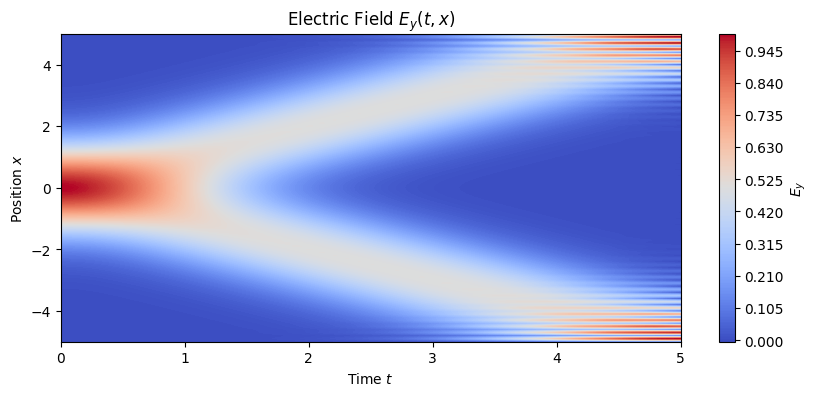

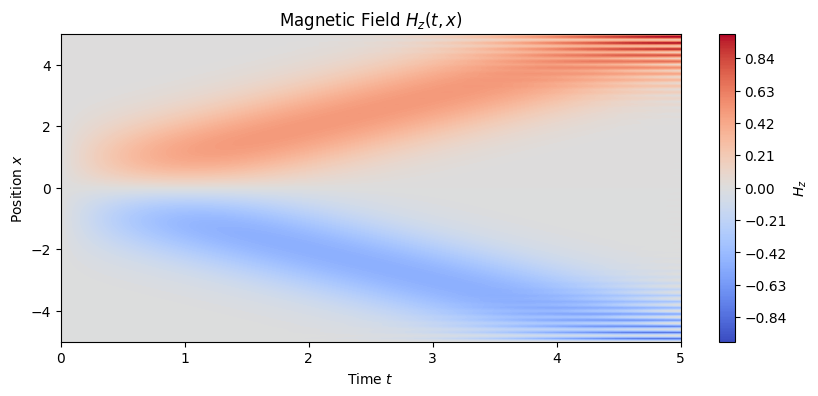

In [ ]:
# Parameters
xspan = (-5.0, 5.0)
tspan = (0.0, 5.0)
dx = 0.1
dt = 0.01
xgrid = np.arange(xspan[0], xspan[1] + dx, dx)
tgrid = np.arange(tspan[0], tspan[1] + dt, dt)
mu = 1.0  # Permeability
epsilon = 1.0  # Permittivity

# Initial conditions (Gaussian pulse for E_y, H_z initially zero)
def gaussian(x, x0=0.0, sigma=1.0):
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

Ey_init = gaussian(xgrid, x0=0.0, sigma=1.0)
Hz_init = np.zeros_like(xgrid)

# Discretization
def maxwell_rhs(t, y, dx, N, mu, epsilon):
    Ey = y[:N]
    Hz = y[N:]
    dEy_dx = np.zeros_like(Ey)
    dHz_dx = np.zeros_like(Hz)

    # Finite difference (PEC boundary conditions)
    for i in range(1, N-1):
        dEy_dx[i] = (Ey[i+1] - Ey[i-1]) / (2 * dx)
        dHz_dx[i] = (Hz[i+1] - Hz[i-1]) / (2 * dx)

    # PEC boundary conditions (Ey=0 at boundaries)
    dEy_dx[0] = dEy_dx[-1] = 0
    dHz_dx[0] = dHz_dx[-1] = 0

    # RHS of Maxwell's equations
    dEy_dt = -(1 / epsilon) * dHz_dx
    dHz_dt = -(1 / mu) * dEy_dx

    return np.concatenate([dEy_dt, dHz_dt])

# Solve the system
N = len(xgrid)
y0 = np.concatenate([Ey_init, Hz_init])
sol = solve_ivp(maxwell_rhs, tspan, y0, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

# Extract solutions
Ey_sol = sol.y[:N, :]
Hz_sol = sol.y[N:, :]

# Plot Electric Field E_y
plt.figure(figsize=(10, 4))
plt.contourf(sol.t, xgrid, Ey_sol, levels=201, cmap='coolwarm')
plt.colorbar(label='$E_y$')
plt.xlabel('Time $t$')
plt.ylabel('Position $x$')
plt.title('Electric Field $E_y(t, x)$')
plt.show()

# Plot Magnetic Field H_z
plt.figure(figsize=(10, 4))
plt.contourf(sol.t, xgrid, Hz_sol, levels=201, cmap='coolwarm')
plt.colorbar(label='$H_z$')
plt.xlabel('Time $t$')
plt.ylabel('Position $x$')
plt.title('Magnetic Field $H_z(t, x)$')
plt.show()


# Fourier Neural Operator


##FNO Module

In [ ]:
# Extract training data from the Maxwell solution
idx_ = [10, 30, 50, 70, 90, 110, 130, 150]
dt_train = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
Ey_train = np.array([Ey_sol[:, idx] for idx in idx_])
Hz_train = np.array([Hz_sol[:, idx] for idx in idx_])
time_steps = np.array(dt_train)
gtgrid = np.arange(tspan[0], dt_train[-1] + dt, dt)
Ey_gt_train = np.array(Ey_sol[:, int(dt_train[-1]/dt):])
Hz__gt_train = np.array(Hz_sol[:, int(dt_train[-1]/dt):])
# FNO Components
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat)
        )

    def forward(self, x):
        x_ft = torch.fft.rfft(x, dim=-1)
        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft[..., : self.modes] = torch.einsum(
            "bix,iox->box", x_ft[..., : self.modes], self.weights1
        )
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width)  # 3: spatial, temporal, field component

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)  # Output: Ey and Hz components

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = nn.ReLU()(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = nn.ReLU()(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x


# Prepare data
spatial_grid = np.repeat(xgrid.reshape(1, -1), len(time_steps), axis=0)
temporal_grid = np.repeat(time_steps.reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input
input_data = np.stack([spatial_grid, temporal_grid, Ey_train], axis=-1)
output_data = np.stack([Ey_train, Hz_train], axis=-1)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

##Preparing Testing Dataset

In [ ]:
# Define the test time grid
dt_test = np.arange(0, 1.6, 0.2)  # Test times from 1.5 to 5.0 with spacing of 0.1

# Extract test data for Ey and Hz
Ey_test = np.array([Ey_sol[:, int(t / dt)] for t in dt_test])
Hz_test = np.array([Hz_sol[:, int(t / dt)] for t in dt_test])

# Prepare test dataset for input and output
spatial_test_grid = np.repeat(xgrid.reshape(1, -1), len(dt_test), axis=0)
temporal_test_grid = np.repeat(dt_test.reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input for testing
input_data_test = np.stack([spatial_test_grid, temporal_test_grid, Ey_test], axis=-1)
output_data_test = np.stack([Ey_test, Hz_test], axis=-1)

# Convert test data to PyTorch tensors
input_tensor_test = torch.tensor(input_data_test, dtype=torch.float32)
output_tensor_test = torch.tensor(output_data_test, dtype=torch.float32)

print("Testing dataset prepared.")

Testing dataset prepared.


## Changing the hyper parameters

Training model with modes=2, width=32
Epoch 0, Training Loss: 0.10017576068639755, Testing Loss: 0.08624090254306793
Epoch 100, Training Loss: 6.973124982323498e-05, Testing Loss: 8.97184872883372e-05
Epoch 200, Training Loss: 9.011587280838285e-06, Testing Loss: 1.5601885024807416e-05
Epoch 300, Training Loss: 4.5611236600962e-06, Testing Loss: 1.0125714652531315e-05
Epoch 400, Training Loss: 3.183000671924674e-06, Testing Loss: 7.966825251060072e-06
Epoch 500, Training Loss: 2.4000078155950177e-06, Testing Loss: 6.864204806333873e-06
Epoch 600, Training Loss: 1.931548922584625e-06, Testing Loss: 6.068358288757736e-06
Epoch 700, Training Loss: 1.7668971850071102e-06, Testing Loss: 5.720416538679274e-06
Epoch 800, Training Loss: 1.5679936495871516e-06, Testing Loss: 5.502981821337016e-06
Epoch 900, Training Loss: 1.3383612440520665e-06, Testing Loss: 5.252451956039295e-06
Epoch 1000, Training Loss: 1.1991362498520175e-06, Testing Loss: 5.004690137866419e-06
Epoch 1100, Training Loss: 6

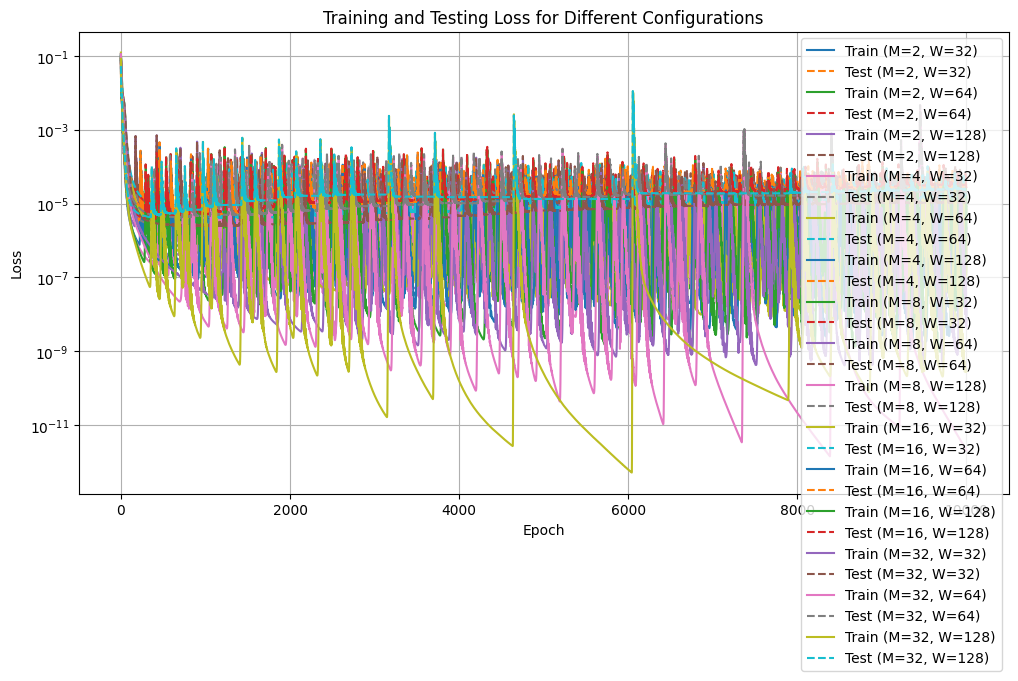

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Function to count the number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and benchmark the FNO model
def train_and_benchmark_fno_with_test(
    modes, width, lr, epochs, input_tensor, output_tensor, input_tensor_test, output_tensor_test, save_path="model.pth"
):
    fno_model = FNO1d(modes, width)
    optimizer = torch.optim.Adam(fno_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Count the number of model parameters
    num_parameters = count_parameters(fno_model)

    # Initialize tracking variables
    start_time = time.time()
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        # Training step
        fno_model.train()
        optimizer.zero_grad()
        predictions = fno_model(input_tensor)
        train_loss = loss_fn(predictions, output_tensor)
        train_loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(train_loss.item())

        # Testing step
        fno_model.eval()
        with torch.no_grad():
            test_predictions = fno_model(input_tensor_test)
            test_loss = loss_fn(test_predictions, output_tensor_test)
            test_loss_history.append(test_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Testing Loss: {test_loss.item()}")

    # Measure training time
    training_time = time.time() - start_time

    # Measure inference time
    fno_model.eval()
    start_inference = time.time()
    with torch.no_grad():
        fno_model(input_tensor_test)
    inference_time = time.time() - start_inference

    # Save the trained model
    torch.save(fno_model.state_dict(), save_path)

    return {
        "modes": modes,
        "width": width,
        "lr": lr,
        "epochs": epochs,
        "training_time": training_time,
        "inference_time": inference_time,
        "final_train_loss": train_loss_history[-1],
        "final_test_loss": test_loss_history[-1],
        "num_parameters": num_parameters,
        "train_loss_history": train_loss_history,
        "test_loss_history": test_loss_history,
        "model_path": save_path,
    }

# Load existing metrics
if os.path.exists("fno_benchmark_metrics.json"):
    with open("fno_benchmark_metrics.json", "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Training loop
lr = 1e-3
epochs = 10000

# M <= N/2 + 1 = 51
modes_range = [2,4,8,16,32]
width_range = [32, 64, 128]

for modes in modes_range:
    for width in width_range:
        print(f"Training model with modes={modes}, width={width}")
        save_path = f"fno_model_modes_{modes}_width_{width}.pth"
        metrics = train_and_benchmark_fno_with_test(
            modes=modes,
            width=width,
            lr=lr,
            epochs=epochs,
            input_tensor=input_tensor,
            output_tensor=output_tensor,
            input_tensor_test=input_tensor_test,
            output_tensor_test=output_tensor_test,
            save_path=save_path,
        )
        all_metrics.append(metrics)

        # Save metrics incrementally
        with open("fno_benchmark_metrics.json", "w") as f:
            json.dump(all_metrics, f, indent=4)

        print(f"Metrics for modes={modes}, width={width} saved.")

# Plot training and testing loss for all configurations
plt.figure(figsize=(12, 6))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label=f"Train (M={metrics['modes']}, W={metrics['width']})",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_history"],
        linestyle="--",
        label=f"Test (M={metrics['modes']}, W={metrics['width']})",
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for Different Configurations")
plt.legend()
plt.grid(True)
plt.show()


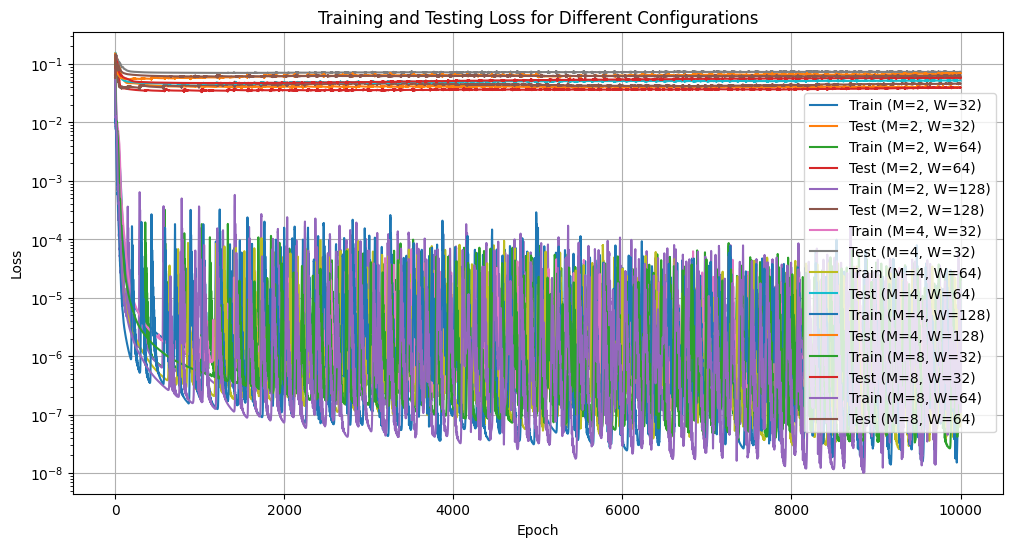

In [ ]:
# Plot training and testing loss for all configurations
plt.figure(figsize=(12, 6))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label=f"Train (M={metrics['modes']}, W={metrics['width']})",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_history"],
        label=f"Test (M={metrics['modes']}, W={metrics['width']})",
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for Different Configurations")
plt.legend()
plt.grid(True)
plt.show()

##Unmounts Google Drive from Colab

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import os

# List all files and directories in the current directory
files = os.listdir()
print("Files and directories in the current working directory:")
for file in files:
    print(file)


Files and directories in the current working directory:
.config
kanode_model_grid_5_node_10.pth
kanode_testing_metrics.json
sample_data


##WARNING: This deletes files saved in current directory. If your Google Drive is mounted, it will delete files from your Google Drive too. Unmout Google Drive before proceeding.

In [ ]:
import os
import shutil

# Delete all files and folders in the current directory
for file_name in os.listdir():
    file_path = os.path.join(os.getcwd(), file_name)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove the directory
        print(f"Deleted: {file_name}")
    except Exception as e:
        print(f"Failed to delete {file_name}: {e}")


Deleted: .config
Deleted: kanode_model_grid_5_node_10.pth
Deleted: kanode_testing_metrics.json
Deleted: sample_data


##Save all the trained models and metrics in Google Drive

In [ ]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the target directory in Google Drive
target_dir = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final2/'

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Copy all saved models to the target directory
for metrics in all_metrics:
    model_path = metrics["model_path"]  # Get the saved model path from metrics
    if os.path.exists(model_path):  # Check if the model file exists
        shutil.copy(model_path, target_dir)
    else:
        print(f"Model file {model_path} not found!")

# Copy metrics file to the target directory
if os.path.exists("fno_benchmark_metrics.json"):
    shutil.copy("fno_benchmark_metrics.json", target_dir)
else:
    print("Metrics file not found!")

print(f"All models and metrics have been saved to: {target_dir}")

Mounted at /content/drive
All models and metrics have been saved to: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final2/


##Loading the saved models from Google Drive and plotting metrics

In [ ]:
from google.colab import drive
import os
import torch
import json

# Mount Google Drive
drive.mount('/content/drive')

# Define the target directory in Google Drive
source_dir = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/'

# Load metrics from the JSON file
metrics_file = os.path.join(source_dir, "fno_benchmark_metrics.json")
if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        all_metrics = json.load(f)
    print("Metrics loaded successfully!")
else:
    print(f"Metrics file not found in {source_dir}!")

# Load models from the saved paths
loaded_models = {}
for metrics in all_metrics:
    model_path = os.path.join(source_dir, os.path.basename(metrics["model_path"]))
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")
        fno_model = FNO1d(metrics["modes"], metrics["width"])  # Recreate the FNO model architecture
        fno_model.load_state_dict(torch.load(model_path))
        fno_model.eval()
        loaded_models[f'M={metrics["modes"]}_W={metrics["width"]}'] = fno_model
    else:
        print(f"Model file {model_path} not found!")

# Print loaded models
print(f"Loaded models: {list(loaded_models.keys())}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metrics loaded successfully!
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_2_width_8.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_2_width_16.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_2_width_64.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_2_width_128.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_2_width_256.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_4_width_8.pth

<ipython-input-20-b5a593f5ad08>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fno_model.load_state_dict(torch.load(model_path))


Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_16_width_8.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_16_width_16.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_16_width_64.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_16_width_128.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_16_width_256.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_32_width_8.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO/fno_model_modes_32_width_16.pth...
Loadin

##FNO Results

###Times Plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


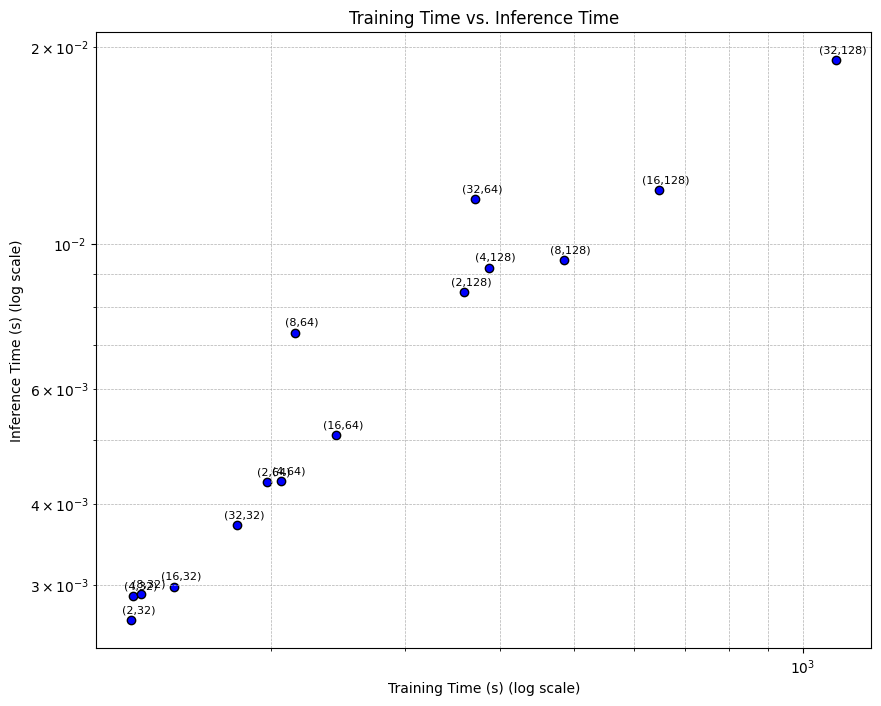

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Times.pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your JSON file in Google Drive
file_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final2/fno_benchmark_metrics.json"

# Load metrics from the JSON file
with open(file_path, "r") as f:
    filtered_metrics = json.load(f)

# Extract data from metrics
training_times = [metrics["training_time"] for metrics in filtered_metrics]
inference_times = [metrics["inference_time"] for metrics in filtered_metrics]
min_train_losses = [min(metrics["train_loss_history"]) for metrics in filtered_metrics]  # Minimum training loss
num_parameters = [metrics["num_parameters"] for metrics in filtered_metrics]
modes = [metrics["modes"] for metrics in filtered_metrics]  # Number of modes (M)
widths = [metrics["width"] for metrics in filtered_metrics]  # Width (W)

# Plot 1: Training Time vs. Inference Time
plt.figure(figsize=(10, 8))

# Training Time vs. Inference Time
plt.scatter(training_times, inference_times, color="blue", edgecolor="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training Time (s) (log scale)")
plt.ylabel("Inference Time (s) (log scale)")
plt.title("Training Time vs. Inference Time")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Add annotations for modes (M) and widths (W)
for i in range(len(training_times)):
    plt.annotate(f"({modes[i]},{widths[i]})",
                 (training_times[i], inference_times[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center", fontsize=8)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Times.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


###Scaling Plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


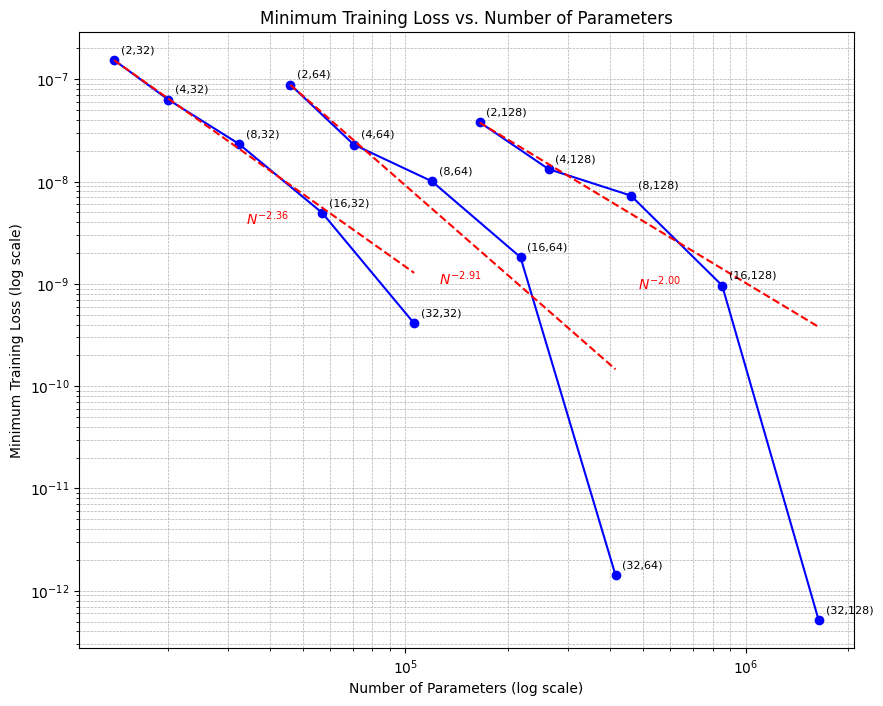

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Scaling.pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.optimize import curve_fit
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your JSON file in Google Drive
file_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final2/fno_benchmark_metrics.json"

# Load metrics from the JSON file
with open(file_path, "r") as f:
    filtered_metrics = json.load(f)

# Extract data from metrics
training_times = [metrics["training_time"] for metrics in filtered_metrics]
inference_times = [metrics["inference_time"] for metrics in filtered_metrics]
min_train_losses = [min(metrics["train_loss_history"]) for metrics in filtered_metrics]  # Minimum training loss
num_parameters = [metrics["num_parameters"] for metrics in filtered_metrics]
modes = [metrics["modes"] for metrics in filtered_metrics]  # Number of modes (M)
widths = [metrics["width"] for metrics in filtered_metrics]  # Width (W)

# Fit function
def scaling_law(x, C, alpha):
    return C * (x ** alpha)

# Group points by width
unique_widths = sorted(set(widths))
width_groups = {w: {"num_params": [], "min_loss": [], "modes": []} for w in unique_widths}

for i in range(len(widths)):
    width_groups[widths[i]]["num_params"].append(num_parameters[i])
    width_groups[widths[i]]["min_loss"].append(min_train_losses[i])
    width_groups[widths[i]]["modes"].append(modes[i])

# Plot Log-Log Loss vs. Number of Parameters
plt.figure(figsize=(10, 8))

for width, group in width_groups.items():
    # Sort points for each width
    sorted_indices = np.argsort(group["num_params"])
    num_params_sorted = np.array(group["num_params"])[sorted_indices]
    min_loss_sorted = np.array(group["min_loss"])[sorted_indices]
    modes_sorted = np.array(group["modes"])[sorted_indices]

    # Fit scaling law
    params, _ = curve_fit(scaling_law, num_params_sorted, min_loss_sorted)
    C, alpha = params

    # Generate piecewise line
    plt.plot(num_params_sorted, min_loss_sorted, linestyle="-", marker="o", color="blue", linewidth=1.5)

    # Generate fitted line
    fitted_y = scaling_law(num_params_sorted, C, alpha)
    plt.plot(num_params_sorted, fitted_y, linestyle="--", color="red", linewidth=1.5)

    # Annotate (M, W) for each point
    for x, y, mode in zip(num_params_sorted, min_loss_sorted, modes_sorted):
        plt.annotate(f"({mode},{width})", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8)

    # Annotate the scaling law ~N^alpha
    mid_x = np.median(num_params_sorted)
    mid_y = scaling_law(mid_x, C, alpha)
    plt.text(1.2*mid_x, 0.18*mid_y, f"$~N^{{{alpha:.2f}}}$", fontsize=10, ha="center", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Parameters (log scale)")
plt.ylabel("Minimum Training Loss (log scale)")
plt.title("Minimum Training Loss vs. Number of Parameters")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Scaling.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


###Loss Curve

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


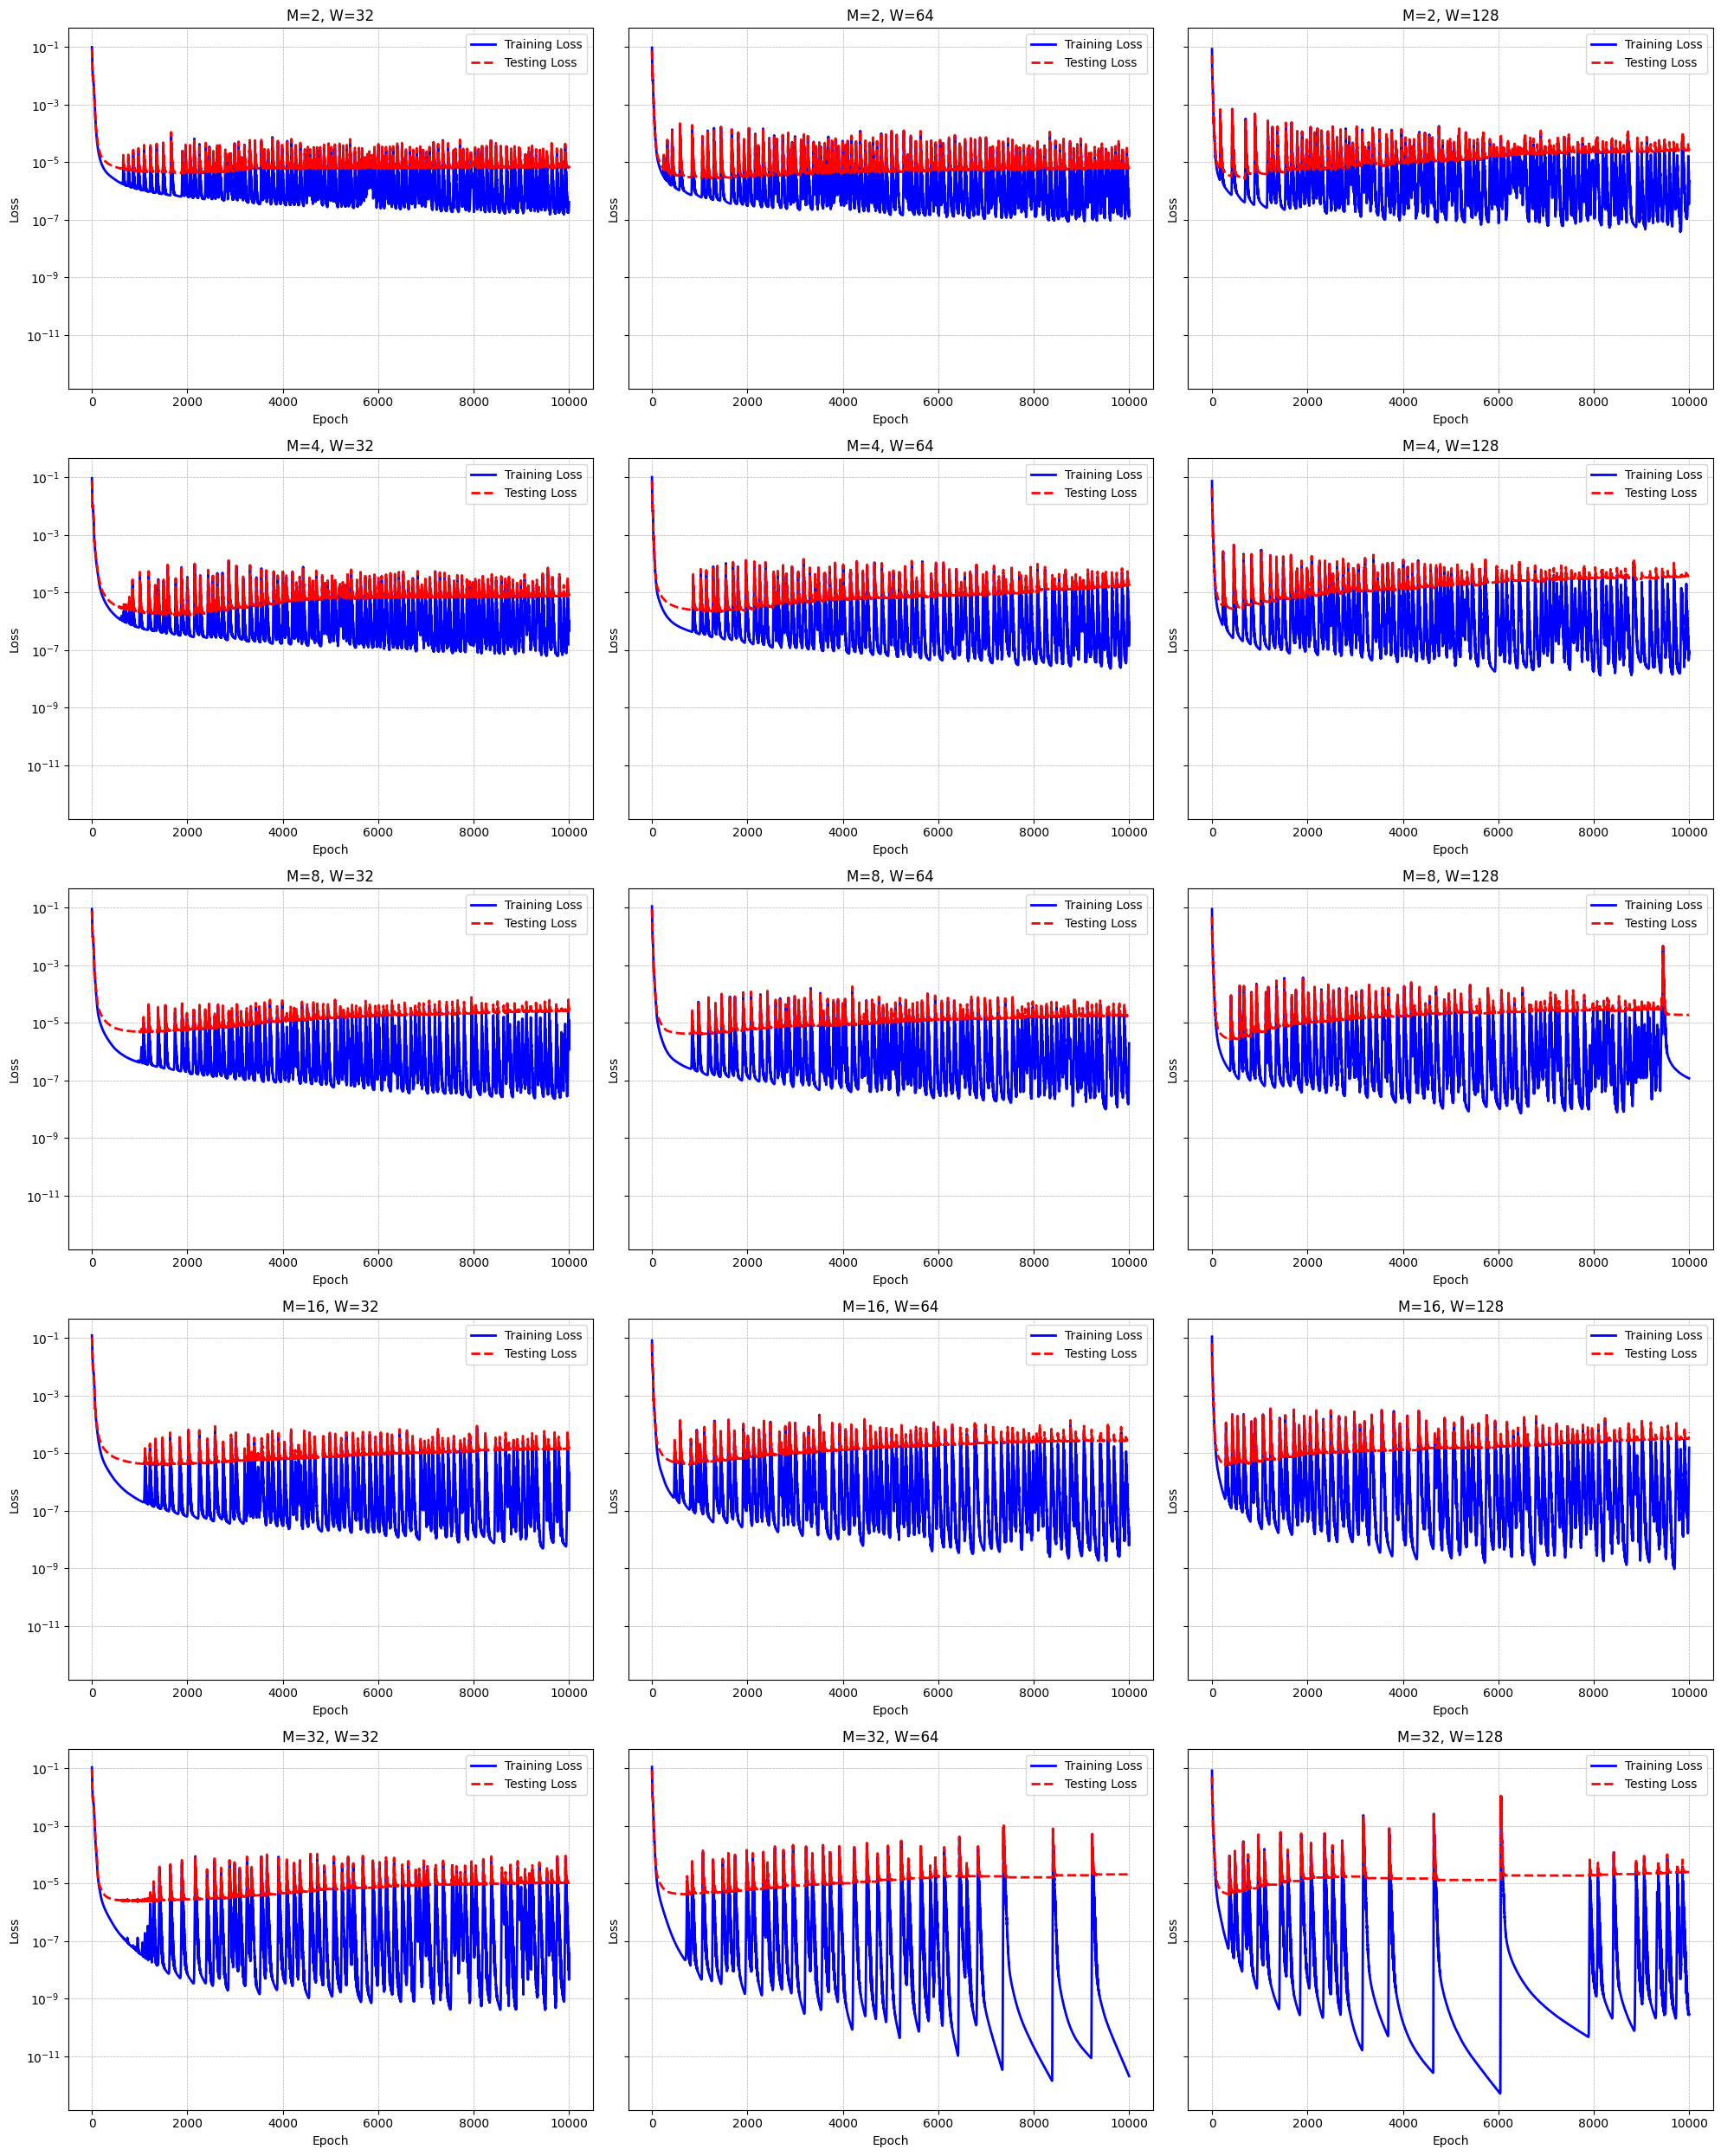

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Loss.pdf


In [ ]:
import matplotlib.pyplot as plt
import json
import math
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your JSON file in Google Drive
file_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final2/fno_benchmark_metrics.json"

# Load metrics from the JSON file
with open(file_path, "r") as f:
    filtered_metrics = json.load(f)

# Determine the number of configurations
num_configs = len(filtered_metrics)

# Calculate rows and columns for subplots
cols = 3  # Set the number of columns
rows = math.ceil(num_configs / cols)  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharey=True)
axes = axes.flatten()  # Flatten for easy indexing

# Plot each configuration
for i, metrics in enumerate(filtered_metrics):
    modes = metrics["modes"]
    widths = metrics["width"]
    train_loss_history = metrics["train_loss_history"]
    test_loss_history = metrics["test_loss_history"]

    # Plot training and testing loss in the respective subplot
    axes[i].plot(train_loss_history, label="Training Loss", color="blue", linewidth=2)
    axes[i].plot(test_loss_history, label="Testing Loss", color="red", linestyle="--", linewidth=2)

    # Configure subplot
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
    axes[i].set_title(f"M={modes}, W={widths}")
    axes[i].legend()
    axes[i].grid(True, which="both", linestyle="--", linewidth=0.5)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Loss.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


##FNO Field Visualization

Here we plot the FNO predictions, and compare them with the ground truth values for $E_{y}$ and $H_{z}$. In order to describe the accuracy of the prediction, we defined the error function as:
$$
\text{Error}_E = | E_P - E_T |
$$
We define the same form for H as follows:
$$
\text{Error}_H = | H_P - H_T|
$$

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metrics loaded successfully!
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_2_width_32.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_2_width_64.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_2_width_128.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_4_width_32.pth...


<ipython-input-68-2dd012275e44>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fno_model.load_state_dict(torch.load(model_path))


Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_4_width_64.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_4_width_128.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_8_width_32.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_8_width_64.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_8_width_128.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fno_model_modes_16_width_32.pth...
Loading model from /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/fn

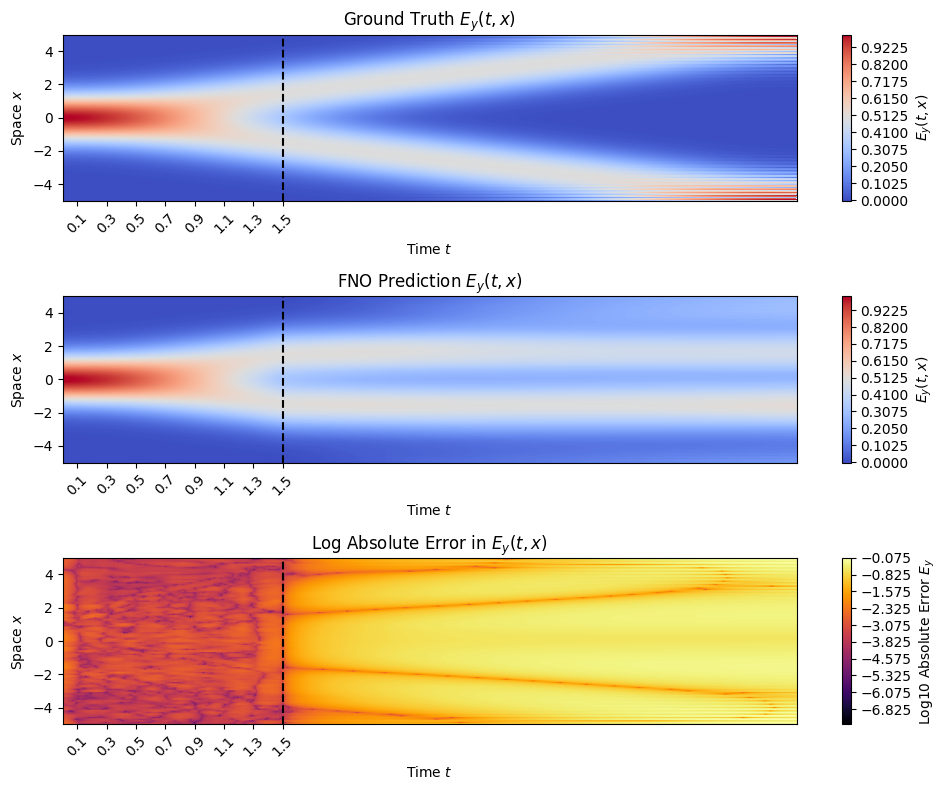

Plot saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_field_visual.pdf


In [ ]:
#Load the saved model for M = 8, W = 32
from google.colab import drive
import os
import torch
import json

# Mount Google Drive
drive.mount('/content/drive')

# Define the target directory in Google Drive
source_dir = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/FNO_final/'

# Load metrics from the JSON file
metrics_file = os.path.join(source_dir, "fno_benchmark_metrics.json")
if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        all_metrics = json.load(f)
    print("Metrics loaded successfully!")
else:
    print(f"Metrics file not found in {source_dir}!")

# Load models from the saved paths
loaded_models = {}
for metrics in all_metrics:
    model_path = os.path.join(source_dir, os.path.basename(metrics["model_path"]))
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")
        fno_model = FNO1d(metrics["modes"], metrics["width"])  # Recreate the FNO model architecture
        fno_model.load_state_dict(torch.load(model_path))
        fno_model.eval()
        loaded_models[f'M={metrics["modes"]}_W={metrics["width"]}'] = fno_model
    else:
        print(f"Model file {model_path} not found!")

fno_visual = loaded_models["M=8_W=32"]

# Prepare data
spatial_grid_vis = np.repeat(xgrid.reshape(1, -1), len(tgrid), axis=0)
temporal_grid_vis = np.repeat(tgrid.reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input
input_data_vis = np.stack([spatial_grid_vis, temporal_grid_vis, Ey_sol.T], axis=-1)
output_data_vis = np.stack([Ey_sol, Hz_sol], axis=-1)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data_vis, dtype=torch.float32)
output_tensor = torch.tensor(output_data_vis, dtype=torch.float32)


# Evaluate the FNO model
fno_visual.eval()  # Set model to evaluation mode
with torch.no_grad():
    pred_output = fno_visual(input_tensor).numpy()  # Shape: (8, len(xgrid), 2)

# Extract predicted E_y and H_z
pred_Ey = pred_output[:, :, 0]  # Predicted E_y
pred_Hz = pred_output[:, :, 1]  # Predicted H_z

# Select ground truth for E_y and H_z at the sampled time steps
Ey_truth_selected = Ey_sol # Ground truth E_y
Hz_truth_selected = Hz_sol  # Ground truth H_z




# Compute absolute errors for E_y and H_z
Ey_abs_error = np.abs(Ey_truth_selected.T - pred_Ey)
Hz_abs_error = np.abs(Hz_truth_selected.T - pred_Hz)



# File path for saving the PDF
output_pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_field_visual.pdf"

# Last training time step
last_training_time = dt_train[-1]
vmin = Ey_sol.min()
vmax = Ey_sol.max()

# Plotting results in one column
plt.figure(figsize=(10, 8))

# Ground Truth E_y (Contour Plot)
plt.subplot(3, 1, 1)
contour_Ey = plt.contourf(tgrid, xgrid, Ey_sol, levels=500, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(contour_Ey, label='$E_y(t,x)$')
plt.title('Ground Truth $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

# Predicted E_y (Contour Plot)
plt.subplot(3, 1, 2)
contour_pred_Ey = plt.contourf(tgrid, xgrid, pred_Ey.T, levels=500, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(contour_pred_Ey, label='$E_y(t,x)$')
plt.title('FNO Prediction $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

# Log Absolute Error E_y (Contour Plot)
plt.subplot(3, 1, 3)
log_Ey_abs_error = np.log10(np.clip(Ey_abs_error, a_min=1e-12, a_max=None))  # Clip to avoid log of 0
contour_log_Ey = plt.contourf(tgrid, xgrid, log_Ey_abs_error.T, levels=500, cmap='inferno')
plt.colorbar(contour_log_Ey, label='Log10 Absolute Error $E_y$')
plt.title('Log Absolute Error in $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

plt.tight_layout()

# Save the figure as a PDF
plt.savefig(output_pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Plot saved as PDF at: {output_pdf_path}")


##Testing

Here we select a particular FNO hyperparameter, M = 8 and W = 32. We use this model, and test it for the following three different testing dataset.

1. Test set A: Interpolated time
2. Test set B: Extrapolated time
3. Test set C: Change the initial condition

###Creating testing datasets

In [ ]:
# Parameters
xspan = (-5.0, 5.0)
tspan = (0.0, 5.0)
dx = 0.1
dt = 0.01
xgrid = np.arange(xspan[0], xspan[1] + dx, dx)
tgrid = np.arange(tspan[0], tspan[1] + dt, dt)
mu = 1.0  # Permeability
epsilon = 1.0  # Permittivity

# Initial conditions (Gaussian pulse for E_y, H_z initially zero)
def gaussian(x, x0=0.0, sigma=1.0):
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

Ey_init = gaussian(xgrid, x0=0.0, sigma=1.0)
Hz_init = np.zeros_like(xgrid)

Ey_init2 = gaussian(xgrid, x0=2.0, sigma=1.0)
Hz_init2 = np.zeros_like(xgrid)

Ey_init3 = gaussian(xgrid, x0=0.0, sigma=2.0)
Hz_init3 = np.zeros_like(xgrid)

# Discretization
def maxwell_rhs(t, y, dx, N, mu, epsilon):
    Ey = y[:N]
    Hz = y[N:]
    dEy_dx = np.zeros_like(Ey)
    dHz_dx = np.zeros_like(Hz)

    # Finite difference (PEC boundary conditions)
    for i in range(1, N-1):
        dEy_dx[i] = (Ey[i+1] - Ey[i-1]) / (2 * dx)
        dHz_dx[i] = (Hz[i+1] - Hz[i-1]) / (2 * dx)

    # PEC boundary conditions (Ey=0 at boundaries)
    dEy_dx[0] = dEy_dx[-1] = 0
    dHz_dx[0] = dHz_dx[-1] = 0

    # RHS of Maxwell's equations
    dEy_dt = -(1 / epsilon) * dHz_dx
    dHz_dt = -(1 / mu) * dEy_dx

    return np.concatenate([dEy_dt, dHz_dt])

# Solve the system
N = len(xgrid)
y0 = np.concatenate([Ey_init, Hz_init])
sol = solve_ivp(maxwell_rhs, tspan, y0, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

y2 = np.concatenate([Ey_init2, Hz_init2])
sol2 = solve_ivp(maxwell_rhs, tspan, y2, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

y3 = np.concatenate([Ey_init3, Hz_init3])
sol3 = solve_ivp(maxwell_rhs, tspan, y3, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

# Extract solutions
Ey_sol = sol.y[:N, :]
Hz_sol = sol.y[N:, :]

Ey_sol2 = sol2.y[:N, :]
Hz_sol2 = sol2.y[N:, :]

Ey_sol3 = sol3.y[:N, :]
Hz_sol3 = sol3.y[N:, :]

# Extract training data from the Maxwell solution
idx_ = [10, 30, 50, 70, 90, 110, 130, 150]
dt_train = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
Ey_train = np.array([Ey_sol[:, idx] for idx in idx_])
Hz_train = np.array([Hz_sol[:, idx] for idx in idx_])
time_steps = np.array(dt_train)

# Prepare data
spatial_grid = np.repeat(xgrid.reshape(1, -1), len(time_steps), axis=0)
temporal_grid = np.repeat(time_steps.reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input
input_data = np.stack([spatial_grid, temporal_grid, Ey_train], axis=-1)
output_data = np.stack([Ey_train, Hz_train], axis=-1)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Define the 2 test time grids
dt_testA = np.arange(0, 1.6, 0.2)  # Test times from 1.5 to 5.0 with spacing of 0.1
dt_testB = np.arange(1.6, 3.2, 0.2)

# Extract test data for Ey and Hz
Ey_testA = np.array([Ey_sol[:, int(t / dt)] for t in dt_testA])
Hz_testA = np.array([Hz_sol[:, int(t / dt)] for t in dt_testA])

Ey_testB = np.array([Ey_sol[:, int(t / dt)] for t in dt_testB])
Hz_testB = np.array([Hz_sol[:, int(t / dt)] for t in dt_testB])

Ey_testC = np.array([Ey_sol2[:, int(t / dt)] for t in dt_train])
Hz_testC = np.array([Hz_sol2[:, int(t / dt)] for t in dt_train])

Ey_testD = np.array([Ey_sol3[:, int(t / dt)] for t in dt_train])
Hz_testD = np.array([Hz_sol3[:, int(t / dt)] for t in dt_train])

# Prepare test dataset for input and output
spatial_test_gridA = np.repeat(xgrid.reshape(1, -1), len(dt_testA), axis=0)
temporal_test_gridA = np.repeat(dt_testA.reshape(-1, 1), len(xgrid), axis=1)

spatial_test_gridB = np.repeat(xgrid.reshape(1, -1), len(dt_testB), axis=0)
temporal_test_gridB = np.repeat(dt_testB.reshape(-1, 1), len(xgrid), axis=1)

spatial_test_gridCD = np.repeat(xgrid.reshape(1, -1), len(dt_train), axis=0)
temporal_test_gridCD = np.repeat(np.array(dt_train).reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input for testing
input_data_testA = np.stack([spatial_test_gridA, temporal_test_gridA, Ey_testA], axis=-1)
output_data_testA = np.stack([Ey_testA, Hz_testA], axis=-1)

input_data_testB = np.stack([spatial_test_gridB, temporal_test_gridB, Ey_testB], axis=-1)
output_data_testB = np.stack([Ey_testB, Hz_testB], axis=-1)

input_data_testC = np.stack([spatial_test_gridCD, temporal_test_gridCD, Ey_testC], axis=-1)
output_data_testC = np.stack([Ey_testC, Hz_testC], axis=-1)

input_data_testD = np.stack([spatial_test_gridCD, temporal_test_gridCD, Ey_testD], axis=-1)
output_data_testD = np.stack([Ey_testD, Hz_testD], axis=-1)

# Convert test data to PyTorch tensors
input_tensor_testA = torch.tensor(input_data_testA, dtype=torch.float32)
output_tensor_testA = torch.tensor(output_data_testA, dtype=torch.float32)

input_tensor_testB = torch.tensor(input_data_testB, dtype=torch.float32)
output_tensor_testB = torch.tensor(output_data_testB, dtype=torch.float32)

input_tensor_testC = torch.tensor(input_data_testC, dtype=torch.float32)
output_tensor_testC = torch.tensor(output_data_testC, dtype=torch.float32)

input_tensor_testD = torch.tensor(input_data_testD, dtype=torch.float32)
output_tensor_testD = torch.tensor(output_data_testD, dtype=torch.float32)


print("Testing dataset prepared.")

Testing dataset prepared.


###Training

In [ ]:
# Function to train and benchmark the FNO model
def fno_training_test(
    modes, width, lr, epochs, input_tensor, output_tensor, input_tensor_test, output_tensor_test, save_path="model.pth"
):
    fno_model = FNO1d(modes, width)
    optimizer = torch.optim.Adam(fno_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_loss_history = []
    test_loss_historyA = []
    test_loss_historyB = []
    test_loss_historyC = []
    test_loss_historyD = []

    for epoch in range(epochs):
        # Training step
        fno_model.train()
        optimizer.zero_grad()
        predictions = fno_model(input_tensor)
        train_loss = loss_fn(predictions, output_tensor)
        train_loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(train_loss.item())

        # Testing step
        fno_model.eval()
        with torch.no_grad():
            test_predictionsA = fno_model(input_tensor_test[0])
            test_lossA = loss_fn(test_predictionsA, output_tensor_test[0])
            test_loss_historyA.append(test_lossA.item())

            test_predictionsB = fno_model(input_tensor_test[1])
            test_lossB = loss_fn(test_predictionsB, output_tensor_test[1])
            test_loss_historyB.append(test_lossB.item())

            test_predictionsC = fno_model(input_tensor_test[2])
            test_lossC = loss_fn(test_predictionsC, output_tensor_test[2])
            test_loss_historyC.append(test_lossC.item())

            test_predictionsD = fno_model(input_tensor_test[2])
            test_lossD = loss_fn(test_predictionsD, output_tensor_test[2])
            test_loss_historyD.append(test_lossD.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Testing Loss A: {test_lossA.item()}, Testing Loss B: {test_lossB.item()}, Testing Loss C: {test_lossC.item()}, Testing Loss D: {test_lossD.item()}")

    # Save the trained model
    torch.save(fno_model.state_dict(), save_path)

    return {
        "modes": modes,
        "width": width,
        "lr": lr,
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "test_loss_historyA": test_loss_historyA,
        "test_loss_historyB": test_loss_historyB,
        "test_loss_historyC": test_loss_historyC,
        "test_loss_historyD": test_loss_historyD,
        "model_path": save_path,
    }

###Plotting

Training model with modes=8, width=32
Epoch 0, Training Loss: 0.09357745200395584, Testing Loss A: 0.08108789473772049, Testing Loss B: 0.08159046620130539, Testing Loss C: 0.08136569708585739, Testing Loss D: 0.08136569708585739
Epoch 100, Training Loss: 0.00013749390200246125, Testing Loss A: 0.0001791208633221686, Testing Loss B: 0.022986091673374176, Testing Loss C: 0.10207127779722214, Testing Loss D: 0.10207127779722214
Epoch 200, Training Loss: 5.566146228375146e-06, Testing Loss A: 1.364151557936566e-05, Testing Loss B: 0.01744878850877285, Testing Loss C: 0.10222770273685455, Testing Loss D: 0.10222770273685455
Epoch 300, Training Loss: 2.2662245555693517e-06, Testing Loss A: 6.620914973609615e-06, Testing Loss B: 0.016956975683569908, Testing Loss C: 0.10222826153039932, Testing Loss D: 0.10222826153039932
Epoch 400, Training Loss: 1.366504193356377e-06, Testing Loss A: 5.337866696208948e-06, Testing Loss B: 0.016610387712717056, Testing Loss C: 0.10220667719841003, Testing L

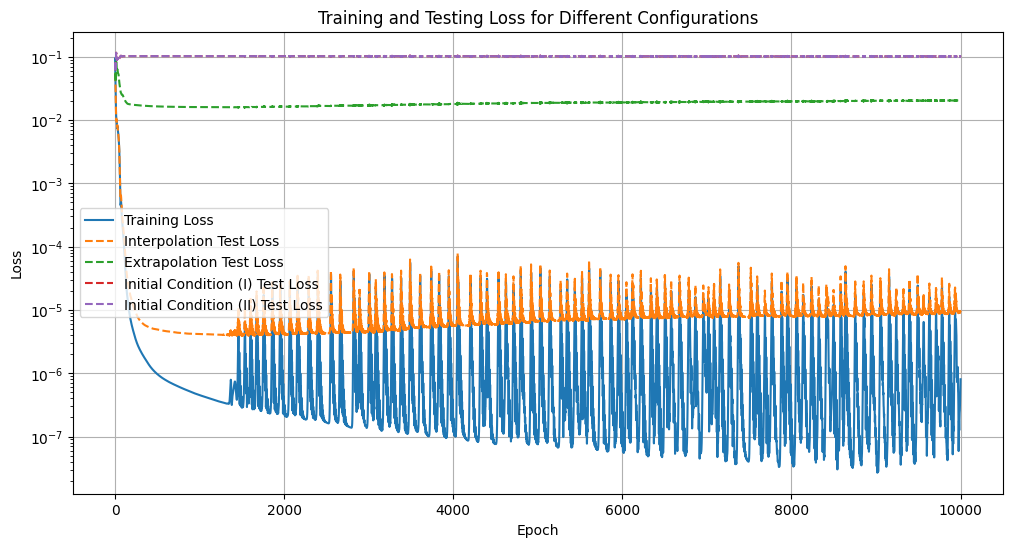

In [ ]:
import os
import matplotlib.pyplot as plt
import json
import math
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load existing metrics
if os.path.exists("fno_testing_metrics.json"):
    with open("fno_testing_metrics.json", "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Training loop
lr = 1e-3
epochs = 10000

# M <= N/2 + 1 = 51
modes_range = [8]
width_range = [32]

for modes in modes_range:
    for width in width_range:
        print(f"Training model with modes={modes}, width={width}")
        save_path = f"fno_model_modes_{modes}_width_{width}.pth"
        metrics = fno_training_test(
            modes=modes,
            width=width,
            lr=lr,
            epochs=epochs,
            input_tensor=input_tensor,
            output_tensor=output_tensor,
            input_tensor_test=[input_tensor_testA,input_tensor_testB,input_tensor_testC,input_tensor_testD],
            output_tensor_test=[output_tensor_testA,output_tensor_testB,output_tensor_testC,output_tensor_testD],
            save_path=save_path,
        )
        all_metrics.append(metrics)

        # Save metrics incrementally
        with open("fno_testing_metrics.json", "w") as f:
            json.dump(all_metrics, f, indent=4)

        print(f"Metrics for modes={modes}, width={width} saved.")

# Plot training and testing loss for all configurations
plt.figure(figsize=(12, 6))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label="Training Loss",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyA"],
        linestyle="--",
        label="Interpolation Test Loss",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyB"],
        linestyle="--",
        label="Extrapolation Test Loss",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyC"],
        linestyle="--",
        label="Initial Condition (I) Test Loss",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyD"],
        linestyle="--",
        label="Initial Condition (II) Test Loss",
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for Different Configurations")
plt.legend()
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


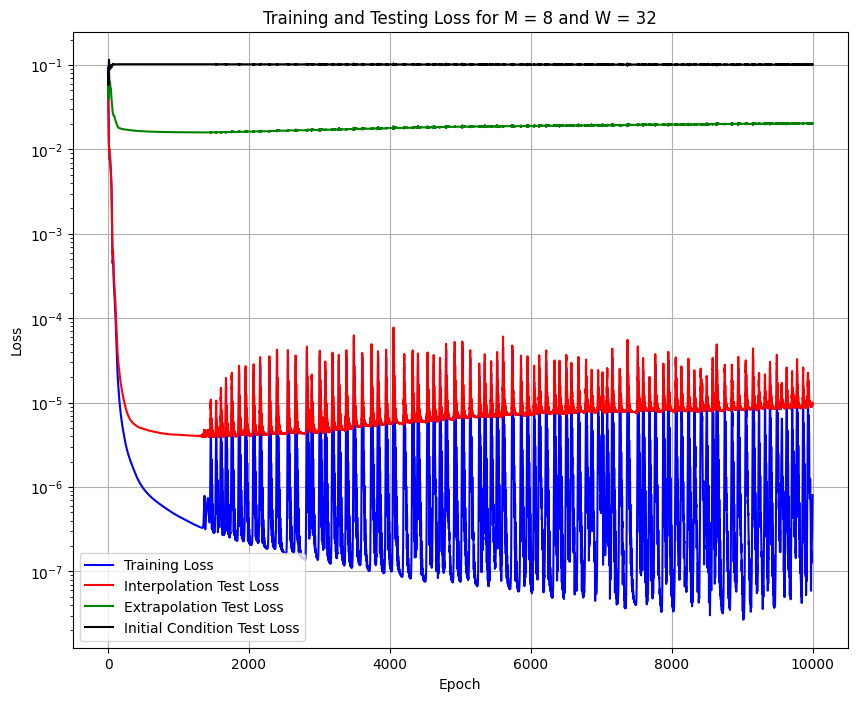

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Testing.pdf


In [ ]:
import os
import matplotlib.pyplot as plt
import json
import math
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Plot training and testing loss for all configurations
plt.figure(figsize=(10, 8))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label="Training Loss",
        color = "blue"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyA"],
        label="Interpolation Test Loss",
        color = "red"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyB"],
        label="Extrapolation Test Loss",
        color = "green"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyD"],
        label="Initial Condition Test Loss",
        color="black"
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for M = 8 and W = 32")
plt.legend()
plt.grid(True)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/FNO_MWL_Testing.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")

#KAN-ODE (Python)

##KAN-ODE Module

- Radial Basis Function (RBF):

The RBF is a mathematical function that transforms inputs into a higher-dimensional space. This transformation helps the model capture complex, smooth variations in the input data.
It works by comparing the input x to predefined grid points z and applying a Gaussian-like formula. The result is a "similarity" measure between the input and the grid points, scaled by a parameter h.
In this context, the RBF is used in the KDense layer to compute non-linear features of the input.

- KDense Layer:

This is a custom neural network layer designed to handle structured data using grid-based computations.
It computes two components:
The spline component uses the RBF to map the input to grid-based features, weighted by a parameter matrix C.
The base component (if enabled) adds a standard dense layer transformation with weights W and applies an activation function. This helps the layer add flexibility to the learned representation.
Together, these components make the KDense layer capable of learning structured, non-linear relationships.

- KANODE Architecture:

The KANODE model is built using two KDense layers:
The first layer compresses the input (size 402, including real and imaginary components) into a smaller latent space (size 10).
The second layer reconstructs the original size (402) from the latent representation.
This two-layer structure provides the capacity to learn compact representations while modeling the dynamics of the input system.

- ODE Solver Integration:

The torchdiffeq library integrates the KANODE model over time, solving the system's evolution as a neural ordinary differential equation (ODE).
The input to the solver is the initial state of the system (y0), which contains the real and imaginary parts of the wavefunction at the starting time.
The solver repeatedly calls the KANODE model to compute how the system evolves at different time steps (t_eval), effectively combining neural networks and ODEs. This lets the model predict the full wavefunction dynamics over time.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Radial Basis Function (RBF)
def rbf(x, z, h):
    return torch.exp(-((x - z) / h) ** 2)

# KDense Layer
class KDense(nn.Module):
    def __init__(self, in_dims, out_dims, grid_len, normalizer=torch.tanh, grid_lims=(-1.0, 1.0), denominator=None, basis_func=rbf, base_act=torch.nn.SiLU(), use_base_act=True):
        super(KDense, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        self.grid_len = grid_len
        self.normalizer = normalizer
        self.grid_lims = torch.tensor(grid_lims, dtype=torch.float32)
        self.denominator = denominator or (2 / (grid_len - 1))
        self.basis_func = basis_func
        self.base_act = base_act
        self.use_base_act = use_base_act

        # Define weights
        self.C = nn.Parameter(torch.empty(out_dims, grid_len * in_dims))
        if use_base_act:
            self.W = nn.Parameter(torch.empty(out_dims, in_dims))
        else:
            self.W = None

        # Initialize weights
        nn.init.xavier_uniform_(self.C)
        if self.use_base_act:
            nn.init.xavier_uniform_(self.W)

        # Create grid
        self.grid = torch.linspace(self.grid_lims[0], self.grid_lims[1], grid_len)

    def forward(self, x):
        batch_size = x.shape[0] if x.ndim > 1 else 1
        x = x.unsqueeze(0) if x.ndim == 1 else x

        x_norm = self.normalizer(x)
        x_reshaped = x_norm.unsqueeze(-1)
        basis = self.basis_func(x_reshaped, self.grid, self.denominator)

        if basis.ndim == 3:
            basis = basis.permute(0, 2, 1).contiguous()
            basis = basis.view(batch_size, -1)
        elif basis.ndim == 2:
            basis = basis.view(-1)

        spline = torch.matmul(basis, self.C.T)

        if self.use_base_act:
            base = torch.matmul(x, self.W.T)
            base = self.base_act(base)
            return spline + base
        else:
            return spline

# KANODE Model
class KANODE(nn.Module):
    def __init__(self, xgrid_len, KANnode, KANgrid):
        super(KANODE, self).__init__()
        self.layer1 = KDense(xgrid_len * 2, KANnode, KANgrid, basis_func=rbf)
        self.layer2 = KDense(KANnode, xgrid_len * 2, KANgrid, basis_func=rbf)

    def forward(self, t, y):
        y = self.layer1(y)
        y = self.layer2(y)
        return y

# Prepare Training Data
idx_ = [10, 30, 50, 70, 90, 110, 130, 150]
dt_train = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
Ey_train = np.array([Ey_sol[:, idx] for idx in idx_])
Hz_train = np.array([Hz_sol[:, idx] for idx in idx_])
time_steps = np.array(dt_train)

# Combine Ey and Hz into the initial conditions
xgrid_len = len(xgrid)
y0_train = torch.tensor(np.hstack([Ey_train[0], Hz_train[0]]), dtype=torch.float32)

# Prepare Ground Truth for Training
ground_truth_train = np.hstack([Ey_train, Hz_train])
ground_truth_tensor_train = torch.tensor(ground_truth_train, dtype=torch.float32)

# Prepare Testing Data
dt_test = np.arange(0, 1.6, 0.2)
Ey_test = np.array([Ey_sol[:, int(t / dt)] for t in dt_test])
Hz_test = np.array([Hz_sol[:, int(t / dt)] for t in dt_test])
ground_truth_test = np.hstack([Ey_test, Hz_test])
ground_truth_tensor_test = torch.tensor(ground_truth_test, dtype=torch.float32)

# Initial conditions for testing
y0_test = torch.tensor(np.hstack([Ey_test[0], Hz_test[0]]), dtype=torch.float32)  # Initial state for testing

# Time points for training evaluation
t_eval_train = torch.tensor(dt_train, dtype=torch.float32)  # Training time points

# Time points for testing evaluation
t_eval_test = torch.tensor(dt_test, dtype=torch.float32)  # Testing time points

print(np.shape(Ey_sol))
print(np.shape(Ey_test))


(101, 501)
(8, 101)


##Training for different hyperparameters

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Function to count the number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and benchmark the KANODE model
def train_and_benchmark_kanode_with_test(
    KANgrid, KANnode, lr, epochs, y0_train, ground_truth_tensor_train, y0_test, ground_truth_tensor_test, t_eval_train, t_eval_test, save_path="kanode_model.pth"
):
    # Instantiate the KANODE model
    kanode = KANODE(len(y0_train) // 2, KANnode, KANgrid)
    optimizer = torch.optim.Adam(kanode.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Count the number of model parameters
    num_parameters = count_parameters(kanode)

    # Initialize tracking variables
    start_time = time.time()
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        # Training step
        optimizer.zero_grad()
        pred_train = odeint(kanode, y0_train, t_eval_train)
        pred_train = pred_train.view(len(t_eval_train), -1)
        train_loss = loss_fn(pred_train, ground_truth_tensor_train)
        train_loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(train_loss.item())

        # Testing step
        with torch.no_grad():
            pred_test = odeint(kanode, y0_test, t_eval_test)
            pred_test = pred_test.view(len(t_eval_test), -1)
            test_loss = loss_fn(pred_test, ground_truth_tensor_test)
            test_loss_history.append(test_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Testing Loss: {test_loss.item()}")

    # Measure training time
    training_time = time.time() - start_time

    # Measure inference time
    kanode.eval()
    start_inference = time.time()
    with torch.no_grad():
        odeint(kanode, y0_test, t_eval_test)
    inference_time = time.time() - start_inference

    # Save the trained model
    torch.save(kanode.state_dict(), save_path)

    return {
        "KANgrid": KANgrid,
        "KANnode": KANnode,
        "lr": lr,
        "epochs": epochs,
        "training_time": training_time,
        "inference_time": inference_time,
        "final_train_loss": train_loss_history[-1],
        "final_test_loss": test_loss_history[-1],
        "num_parameters": num_parameters,
        "train_loss_history": train_loss_history,
        "test_loss_history": test_loss_history,
        "model_path": save_path,
    }

# Load existing metrics
if os.path.exists("kanode_benchmark_metrics.json"):
    with open("kanode_benchmark_metrics.json", "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Training loop
lr = 1e-2
epochs = 1000

# Define range of KANgrid and KANnode
KANgrid_range = [5, 10, 15]
KANnode_range = [10, 20, 30]

for KANgrid in KANgrid_range:
    for KANnode in KANnode_range:
        print(f"Training model with KANgrid={KANgrid}, KANnode={KANnode}")
        save_path = f"kanode_model_grid_{KANgrid}_node_{KANnode}.pth"
        metrics = train_and_benchmark_kanode_with_test(
            KANgrid=KANgrid,
            KANnode=KANnode,
            lr=lr,
            epochs=epochs,
            y0_train=y0_train,
            ground_truth_tensor_train=ground_truth_tensor_train,
            y0_test=y0_test,
            ground_truth_tensor_test=ground_truth_tensor_test,
            t_eval_train=t_eval_train,
            t_eval_test=t_eval_test,
            save_path=save_path,
        )
        all_metrics.append(metrics)

        # Save metrics incrementally
        with open("kanode_benchmark_metrics.json", "w") as f:
            json.dump(all_metrics, f, indent=4)

        print(f"Metrics for KANgrid={KANgrid}, KANnode={KANnode} saved.")

# Plot training and testing loss for all configurations
plt.figure(figsize=(12, 6))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label=f"Train (G={metrics['KANgrid']}, N={metrics['KANnode']})",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_history"],
        linestyle="--",
        label=f"Test (G={metrics['KANgrid']}, N={metrics['KANnode']})",
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for Different Configurations")
plt.legend()
plt.grid(True)
plt.show()


##Save all the trained models and metrics in Google Drive

In [ ]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the target directory in Google Drive for KANODE models
target_dir = '/content/drive/My Drive/Deep_Learning/Trained_Maxwells/KANODE_Final/'

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Copy all saved models to the target directory
for metrics in all_metrics:
    model_path = metrics["model_path"]  # Get the saved model path from metrics
    if os.path.exists(model_path):  # Check if the model file exists
        shutil.copy(model_path, target_dir)
    else:
        print(f"Model file {model_path} not found!")

# Copy metrics file to the target directory
metrics_file = "kanode_benchmark_metrics.json"  # Change the metrics filename for KANODE
if os.path.exists(metrics_file):
    shutil.copy(metrics_file, target_dir)
else:
    print("Metrics file not found!")

print(f"All KANODE models and metrics have been saved to: {target_dir}")


<ipython-input-13-baffd722c5ea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('kanode_model.pth')


KANODE(
  (layer1): KDense(
    (base_act): SiLU()
  )
  (layer2): KDense(
    (base_act): SiLU()
  )
)

##Loading the saved models from Google Drive

In [ ]:
from google.colab import drive
import os
import torch
import json

# Define a default xgrid_len if not present in metrics
default_xgrid_len = len(xgrid)  # Replace `xgrid` with the actual spatial grid used

# Mount Google Drive
drive.mount('/content/drive')

# Define the source directory in Google Drive for KANODE models
source_dir = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_Final/'

# Load metrics from the JSON file
metrics_file = os.path.join(source_dir, "kanode_benchmark_metrics.json")  # Assuming the file is named appropriately
if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        all_metrics = json.load(f)
    print("Metrics loaded successfully!")
else:
    print(f"Metrics file not found in {source_dir}!")

# Load models from the saved paths
loaded_models = {}
for metrics in all_metrics:
    model_path = os.path.join(source_dir, os.path.basename(metrics["model_path"]))
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")
        # Recreate the KANODE model architecture
        kanode_model = KANODE(xgrid_len, metrics["KANnode"], metrics["KANgrid"])
        kanode_model.load_state_dict(torch.load(model_path))
        kanode_model.eval()
        loaded_models[f'Nodes={metrics["KANnode"]}_Grid={metrics["KANgrid"]}'] = kanode_model
    else:
        print(f"Model file {model_path} not found!")

# Print loaded models
print(f"Loaded models: {list(loaded_models.keys())}")


##KAN-ODE Results

###Times plot

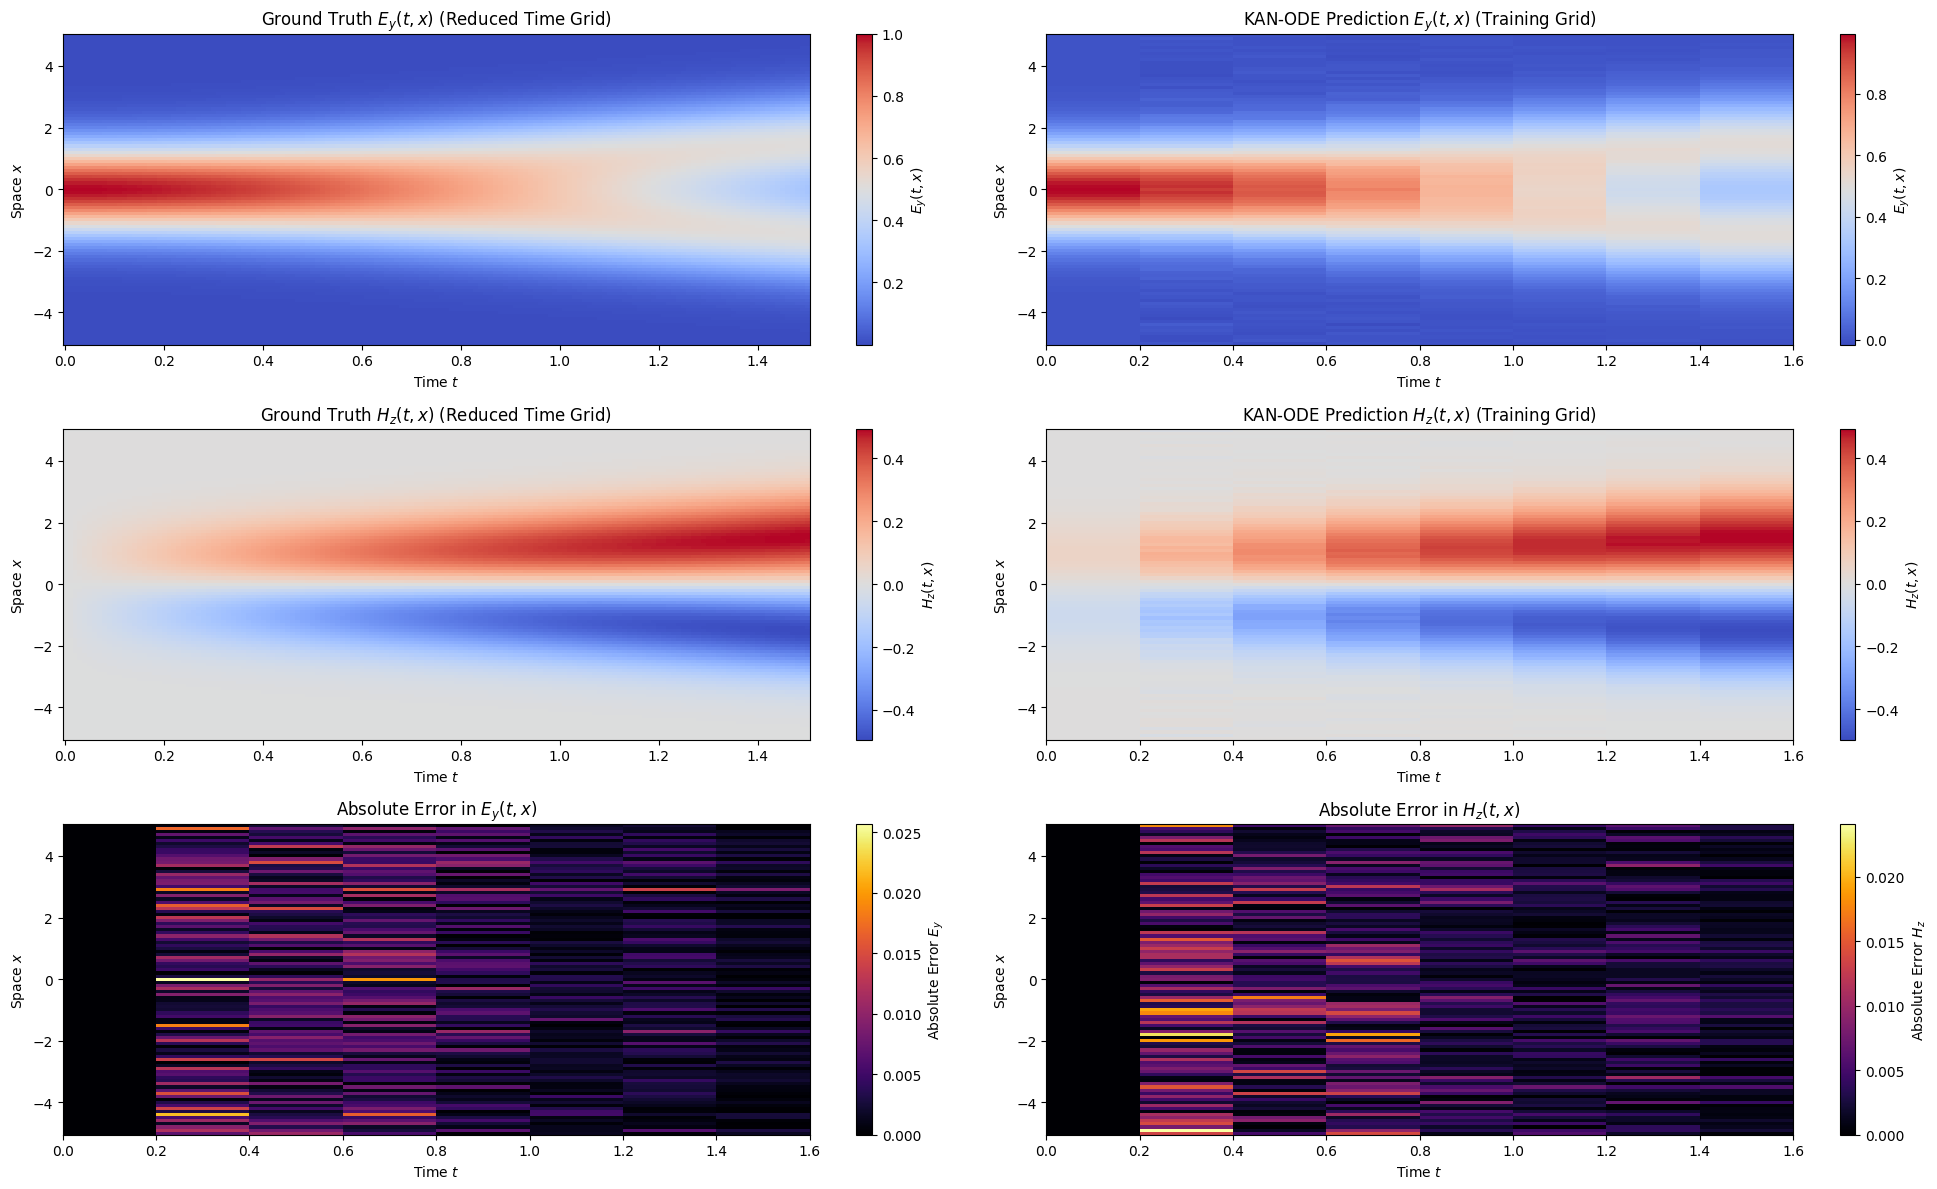

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to your JSON files in Google Drive
file_path1 = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_benchmark_metrics1.json"
file_path2 = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_benchmark_metrics2.json"

# Initialize a list to store combined metrics
filtered_metrics = []

# Load metrics from the first JSON file
if os.path.exists(file_path1):
    with open(file_path1, "r") as f:
        metrics1 = json.load(f)
        filtered_metrics.extend(metrics1)  # Add to the combined list
else:
    print(f"File not found: {file_path1}")

# Load metrics from the second JSON file
if os.path.exists(file_path2):
    with open(file_path2, "r") as f:
        metrics2 = json.load(f)
        filtered_metrics.extend(metrics2)  # Add to the combined list
else:
    print(f"File not found: {file_path2}")

# Extract data from metrics
training_times = [metrics["training_time"] for metrics in filtered_metrics]
inference_times = [metrics["inference_time"] for metrics in filtered_metrics]
min_train_losses = [min(metrics["train_loss_history"]) for metrics in filtered_metrics]  # Minimum training loss
num_parameters = [metrics["num_parameters"] for metrics in filtered_metrics]
kan_grids = [metrics["KANgrid"] for metrics in filtered_metrics]  # KANgrid values
kan_nodes = [metrics["KANnode"] for metrics in filtered_metrics]  # KANnode values

# Plot 1: Training Time vs. Inference Time
plt.figure(figsize=(10, 8))

# Training Time vs. Inference Time (Log-Log)

plt.xscale("log")
plt.yscale("log")
plt.scatter(training_times, inference_times, color="blue", edgecolor="black")
plt.xlabel("Training Time (log scale)")
plt.ylabel("Inference Time (log scale)")
plt.title("Training Time vs. Inference Time")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Add annotations for KANgrid and KANnode
for i in range(len(training_times)):
    plt.annotate(f"({kan_grids[i]},{kan_nodes[i]})",
                 (training_times[i], inference_times[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center", fontsize=8)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_MWL_Times.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


###Scaling plot

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.optimize import curve_fit
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to your JSON files in Google Drive
file_path1 = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_benchmark_metrics1.json"
file_path2 = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_benchmark_metrics2.json"

# Initialize a list to store combined metrics
filtered_metrics = []

# Load metrics from the first JSON file
if os.path.exists(file_path1):
    with open(file_path1, "r") as f:
        metrics1 = json.load(f)
        filtered_metrics.extend(metrics1)  # Add to the combined list
else:
    print(f"File not found: {file_path1}")

# Load metrics from the second JSON file
if os.path.exists(file_path2):
    with open(file_path2, "r") as f:
        metrics2 = json.load(f)
        filtered_metrics.extend(metrics2)  # Add to the combined list
else:
    print(f"File not found: {file_path2}")

# Extract data from metrics
min_train_losses = [min(metrics["train_loss_history"]) for metrics in filtered_metrics]  # Minimum training loss
num_parameters = [metrics["num_parameters"] for metrics in filtered_metrics]
kan_grids = [metrics["KANgrid"] for metrics in filtered_metrics]  # KANgrid values
kan_nodes = [metrics["KANnode"] for metrics in filtered_metrics]  # KANnode values

# Group data by unique KANnode values
unique_nodes = sorted(set(kan_nodes))
node_groups = {node: [] for node in unique_nodes}
for i, node in enumerate(kan_nodes):
    node_groups[node].append((num_parameters[i], min_train_losses[i], kan_grids[i], kan_nodes[i]))

# Define the scaling function
def scaling_law(x, C, alpha):
    return C * (x ** alpha)

# Plot Log-Log Loss vs. Number of Parameters with Scaling Laws
plt.figure(figsize=(10, 8))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Parameters (log scale)")
plt.ylabel("Minimum Training Loss (log scale)")
plt.title("Minimum Training Loss vs. Number of Parameters")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Fit and plot scaling laws for each group
for node, points in node_groups.items():
    points = sorted(points)  # Sort points by number of parameters
    x, y, grids, nodes = zip(*points)
    x = np.array(x)
    y = np.array(y)

    # Fit scaling law
    params, _ = curve_fit(
        scaling_law, x, y, p0=[1e-8, -1], maxfev=10000
    )  # Initial guesses for [C, alpha]
    C, alpha = params

    # Plot points and connect them with lines
    plt.plot(x, y, linestyle="-", marker="o", color="blue", linewidth=1.5)

    # Plot fitted scaling law
    plt.plot(x, scaling_law(x, C, alpha), linestyle="--", color="red", linewidth=1.5)

    # Annotate the scaling law
    mid_x = np.median(x)
    mid_y = scaling_law(mid_x, C, alpha)
    plt.text(1*mid_x, 1.25*mid_y, f"$N^{{{alpha:.2f}}}$", fontsize=10, ha="center", color="red")

    # Annotate points with (G, N)
    for xi, yi, grid, node in zip(x, y, grids, nodes):
        plt.annotate(f"({grid},{node})", (xi, yi), textcoords="offset points", xytext=(5, 5), ha="center", fontsize=8)



# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_MWL_Scaling.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


###Loss Curve

In [ ]:
import matplotlib.pyplot as plt
import json
import math
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to your JSON files in Google Drive
file_path1 = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_benchmark_metrics1.json"
file_path2 = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_benchmark_metrics2.json"

# Initialize a list to store combined metrics
filtered_metrics = []

# Load metrics from the first JSON file
if os.path.exists(file_path1):
    with open(file_path1, "r") as f:
        metrics1 = json.load(f)
        filtered_metrics.extend(metrics1)  # Add to the combined list
else:
    print(f"File not found: {file_path1}")

# Load metrics from the second JSON file
if os.path.exists(file_path2):
    with open(file_path2, "r") as f:
        metrics2 = json.load(f)
        filtered_metrics.extend(metrics2)  # Add to the combined list

# Determine the number of configurations
num_configs = len(filtered_metrics)

# Calculate rows and columns for subplots
cols = 3  # Set the number of columns
rows = math.ceil(num_configs / cols)  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharey=True)
axes = axes.flatten()  # Flatten for easy indexing

# Plot each configuration
for i, metrics in enumerate(filtered_metrics):
    kan_grid = metrics["KANgrid"]
    kan_node = metrics["KANnode"]
    train_loss_history = metrics["train_loss_history"]
    test_loss_history = metrics["test_loss_history"]

    # Plot training and testing loss in the respective subplot
    axes[i].plot(train_loss_history, label="Training Loss", color="blue", linewidth=2)
    axes[i].plot(test_loss_history, label="Testing Loss", color="red", linestyle="--", linewidth=2)

    # Configure subplot
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
    axes[i].set_title(f"G={kan_grid}, N={kan_node}")
    axes[i].legend()
    axes[i].grid(True, which="both", linestyle="--", linewidth=0.5)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_MWL_Loss.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


##Field Visualization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


<ipython-input-91-62538b4b8530>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kanode_visual.load_state_dict(torch.load(trained_model_path, map_location=torch.device('cpu

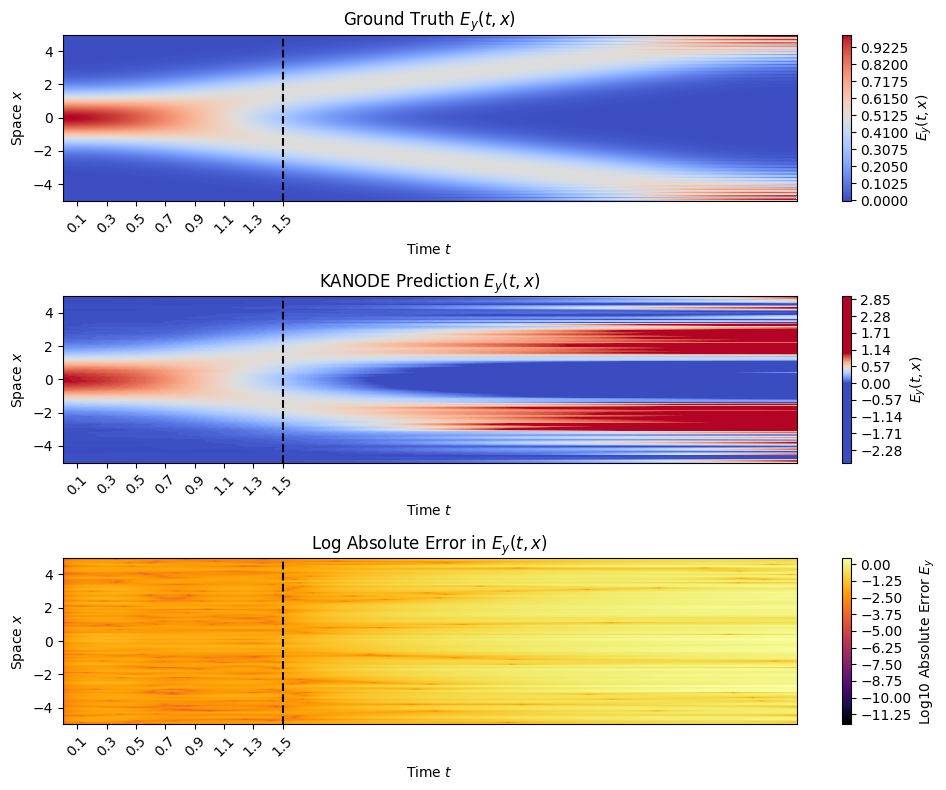

Plot saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_field_visual.pdf


In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import torch

drive.mount('/content/drive')

# Define the path to your trained model in Drive
trained_model_path = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/KANODE_final/kanode_model_grid_5_node_10.pth'

# Define the model parameters
KANgrid = 5
KANnode = 10
xgrid_len = 101  # Example value; replace with the actual spatial grid length
# Prepare initial conditions and time grid
y0_test = torch.tensor(np.hstack([Ey_sol.T[0], Hz_sol.T[0]]), dtype=torch.float32)
#y0_test = y0_test.unsqueeze(0)  # Add batch dimension
t_eval_test = torch.tensor(tgrid, dtype=torch.float32)

# Load the trained model
kanode_visual = KANODE(len(y0_train) // 2, KANnode, KANgrid)  # Ensure the KANODE architecture matches
kanode_visual.load_state_dict(torch.load(trained_model_path, map_location=torch.device('cpu')))
kanode_visual.eval()  # Set the model to evaluation mode

print("Model loaded successfully!")





# Evaluate the model
with torch.no_grad():
    pred_output = odeint(kanode_visual, y0_test, t_eval_test)
    pred_output = pred_output.squeeze(1).numpy()

# Extract predicted fields
pred_Ey = pred_output[:, :xgrid_len]
pred_Hz = pred_output[:, xgrid_len:]

Ey_abs_error = np.abs(Ey_sol.T - pred_Ey)
log_Ey_abs_error = np.log10(np.clip(Ey_abs_error, a_min=1e-12, a_max=None))  # Avoid log(0) by clipping

# File path for saving the PDF
output_pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_field_visual.pdf"

# Plotting results in a single column
plt.figure(figsize=(10, 8))

# Define vmin and vmax based on the ground truth
vmin = Ey_sol.min()
vmax = Ey_sol.max()

# Ground Truth E_y (Contour Plot)
plt.subplot(3, 1, 1)
contour_Ey_truth = plt.contourf(tgrid, xgrid, Ey_sol, levels=500, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(contour_Ey_truth, label='$E_y(t,x)$')
plt.title('Ground Truth $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

# Predicted E_y (Contour Plot)
plt.subplot(3, 1, 2)
contour_pred_Ey = plt.contourf(tgrid, xgrid, pred_Ey.T, levels=500, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(contour_pred_Ey, label='$E_y(t,x)$')
plt.title('KANODE Prediction $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

# Log Absolute Error E_y (Contour Plot)
plt.subplot(3, 1, 3)
contour_log_error = plt.contourf(tgrid, xgrid, log_Ey_abs_error.T, levels=500, cmap='inferno')
plt.colorbar(contour_log_error, label='Log10 Absolute Error $E_y$')
plt.title('Log Absolute Error in $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

plt.tight_layout()

# Save the figure as a PDF
plt.savefig(output_pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Plot saved as PDF at: {output_pdf_path}")



##Testing

Here we select a particular KAN-ODE hyperparameter, G = 5 and N = 10. We use this model, and test it for the following three different testing dataset.

1. Test set A: Interpolated time
2. Test set B: Extrapolated time
3. Test set C: Change the initial condition

###Creating Testing Dataset

In [ ]:
# Parameters
xspan = (-5.0, 5.0)
tspan = (0.0, 5.0)
dx = 0.1
dt = 0.01
xgrid = np.arange(xspan[0], xspan[1] + dx, dx)
tgrid = np.arange(tspan[0], tspan[1] + dt, dt)
mu = 1.0  # Permeability
epsilon = 1.0  # Permittivity

# Initial conditions (Gaussian pulse for E_y, H_z initially zero)
def gaussian(x, x0=0.0, sigma=1.0):
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

Ey_init = gaussian(xgrid, x0=0.0, sigma=1.0)
Hz_init = np.zeros_like(xgrid)

Ey_init2 = gaussian(xgrid, x0=2.0, sigma=1.0)
Hz_init2 = np.zeros_like(xgrid)

Ey_init3 = gaussian(xgrid, x0=0.0, sigma=2.0)
Hz_init3 = np.zeros_like(xgrid)

# Discretization
def maxwell_rhs(t, y, dx, N, mu, epsilon):
    Ey = y[:N]
    Hz = y[N:]
    dEy_dx = np.zeros_like(Ey)
    dHz_dx = np.zeros_like(Hz)

    # Finite difference (PEC boundary conditions)
    for i in range(1, N-1):
        dEy_dx[i] = (Ey[i+1] - Ey[i-1]) / (2 * dx)
        dHz_dx[i] = (Hz[i+1] - Hz[i-1]) / (2 * dx)

    # PEC boundary conditions (Ey=0 at boundaries)
    dEy_dx[0] = dEy_dx[-1] = 0
    dHz_dx[0] = dHz_dx[-1] = 0

    # RHS of Maxwell's equations
    dEy_dt = -(1 / epsilon) * dHz_dx
    dHz_dt = -(1 / mu) * dEy_dx

    return np.concatenate([dEy_dt, dHz_dt])

# Solve the system
N = len(xgrid)
y0 = np.concatenate([Ey_init, Hz_init])
sol = solve_ivp(maxwell_rhs, tspan, y0, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

y2 = np.concatenate([Ey_init2, Hz_init2])
sol2 = solve_ivp(maxwell_rhs, tspan, y2, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

y3 = np.concatenate([Ey_init3, Hz_init3])
sol3 = solve_ivp(maxwell_rhs, tspan, y3, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

# Extract solutions
Ey_sol = sol.y[:N, :]
Hz_sol = sol.y[N:, :]

Ey_sol2 = sol2.y[:N, :]
Hz_sol2 = sol2.y[N:, :]

Ey_sol3 = sol3.y[:N, :]
Hz_sol3 = sol3.y[N:, :]

# Extract training data from the Maxwell solution
idx_ = [10, 30, 50, 70, 90, 110, 130, 150]
dt_train = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
Ey_train = np.array([Ey_sol[:, idx] for idx in idx_])
Hz_train = np.array([Hz_sol[:, idx] for idx in idx_])
time_steps = np.array(dt_train)

# Prepare data
spatial_grid = np.repeat(xgrid.reshape(1, -1), len(time_steps), axis=0)
temporal_grid = np.repeat(time_steps.reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input
input_data = np.stack([spatial_grid, temporal_grid, Ey_train], axis=-1)
output_data = np.stack([Ey_train, Hz_train], axis=-1)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Define the 2 test time grids
dt_testA = np.arange(0, 1.6, 0.2)  # Test times from 1.5 to 5.0 with spacing of 0.1
dt_testB = np.arange(1.6, 3.2, 0.2)

# Extract test data for Ey and Hz
Ey_testA = np.array([Ey_sol[:, int(t / dt)] for t in dt_testA])
Hz_testA = np.array([Hz_sol[:, int(t / dt)] for t in dt_testA])

Ey_testB = np.array([Ey_sol[:, int(t / dt)] for t in dt_testB])
Hz_testB = np.array([Hz_sol[:, int(t / dt)] for t in dt_testB])

Ey_testC = np.array([Ey_sol2[:, int(t / dt)] for t in dt_train])
Hz_testC = np.array([Hz_sol2[:, int(t / dt)] for t in dt_train])

Ey_testD = np.array([Ey_sol3[:, int(t / dt)] for t in dt_train])
Hz_testD = np.array([Hz_sol3[:, int(t / dt)] for t in dt_train])


# Combine Ey and Hz into the initial conditions
xgrid_len = len(xgrid)
y0_train = torch.tensor(np.hstack([Ey_train[0], Hz_train[0]]), dtype=torch.float32)

# Prepare Ground Truth for Training
ground_truth_train = np.hstack([Ey_train, Hz_train])
ground_truth_tensor_train = torch.tensor(ground_truth_train, dtype=torch.float32)

# Prepare Testing Data
ground_truth_testA = np.hstack([Ey_testA, Hz_testA])
ground_truth_tensor_testA = torch.tensor(ground_truth_testA, dtype=torch.float32)

ground_truth_testB = np.hstack([Ey_testB, Hz_testB])
ground_truth_tensor_testB = torch.tensor(ground_truth_testB, dtype=torch.float32)

ground_truth_testC = np.hstack([Ey_testC, Hz_testC])
ground_truth_tensor_testC = torch.tensor(ground_truth_testC, dtype=torch.float32)

ground_truth_testD = np.hstack([Ey_testD, Hz_testD])
ground_truth_tensor_testD = torch.tensor(ground_truth_testD, dtype=torch.float32)

# Initial conditions for testing
y0_testA = torch.tensor(np.hstack([Ey_testA[0], Hz_testA[0]]), dtype=torch.float32)  # Initial state for testing
y0_testB = torch.tensor(np.hstack([Ey_testB[0], Hz_testB[0]]), dtype=torch.float32)
y0_testC = torch.tensor(np.hstack([Ey_testC[0], Hz_testC[0]]), dtype=torch.float32)
y0_testD = torch.tensor(np.hstack([Ey_testD[0], Hz_testD[0]]), dtype=torch.float32)

# Time points for training evaluation
t_eval_train = torch.tensor(dt_train, dtype=torch.float32)  # Training time points

# Time points for testing evaluation
t_eval_testA = torch.tensor(dt_testA, dtype=torch.float32)  # Testing time points
t_eval_testB = torch.tensor(dt_testB, dtype=torch.float32)  # Testing time points
t_eval_testC = torch.tensor(dt_train, dtype=torch.float32)  # Testing time points
t_eval_testD = torch.tensor(dt_train, dtype=torch.float32)  # Testing time points

###Training

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Function to count the number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and benchmark the KANODE model
def kanode_testing(
    KANgrid, KANnode, lr, epochs, y0_train, ground_truth_tensor_train, y0_test, ground_truth_tensor_test, t_eval_train, t_eval_test, save_path="kanode_model.pth"
):
    # Instantiate the KANODE model
    kanode = KANODE(len(y0_train) // 2, KANnode, KANgrid)
    optimizer = torch.optim.Adam(kanode.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Count the number of model parameters
    num_parameters = count_parameters(kanode)

    # Initialize tracking variables
    start_time = time.time()
    train_loss_history = []
    test_loss_historyA = []
    test_loss_historyB = []
    test_loss_historyC = []
    test_loss_historyD = []

    for epoch in range(epochs):
        # Training step
        optimizer.zero_grad()
        pred_train = odeint(kanode, y0_train, t_eval_train)
        pred_train = pred_train.view(len(t_eval_train), -1)
        train_loss = loss_fn(pred_train, ground_truth_tensor_train)
        train_loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(train_loss.item())

        # Testing step
        with torch.no_grad():
            pred_testA = odeint(kanode, y0_test[0], t_eval_test[0])
            pred_testA = pred_testA.view(len(t_eval_test[0]), -1)
            test_lossA = loss_fn(pred_testA, ground_truth_tensor_test[0])
            test_loss_historyA.append(test_lossA.item())

            pred_testB = odeint(kanode, y0_test[1], t_eval_test[1])
            pred_testB = pred_testB.view(len(t_eval_test[1]), -1)
            test_lossB = loss_fn(pred_testB, ground_truth_tensor_test[1])
            test_loss_historyB.append(test_lossB.item())

            pred_testC = odeint(kanode, y0_test[2], t_eval_test[2])
            pred_testC = pred_testC.view(len(t_eval_test[2]), -1)
            test_lossC = loss_fn(pred_testC, ground_truth_tensor_test[2])
            test_loss_historyC.append(test_lossC.item())

            pred_testD = odeint(kanode, y0_test[3], t_eval_test[3])
            pred_testD = pred_testD.view(len(t_eval_test[3]), -1)
            test_lossD = loss_fn(pred_testD, ground_truth_tensor_test[3])
            test_loss_historyD.append(test_lossD.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Testing Loss A: {test_lossA.item()}, Testing Loss B: {test_lossB.item()}, Testing Loss C: {test_lossC.item()}, Testing Loss D: {test_lossD.item()}")

    # Measure training time
    training_time = time.time() - start_time

    # Measure inference time
    kanode.eval()
    start_inference = time.time()
    with torch.no_grad():
        odeint(kanode, y0_testA, t_eval_testA)
    inference_time = time.time() - start_inference

    # Save the trained model
    torch.save(kanode.state_dict(), save_path)

    return {
        "KANgrid": KANgrid,
        "KANnode": KANnode,
        "lr": lr,
        "epochs": epochs,
        "training_time": training_time,
        "inference_time": inference_time,
        "final_train_loss": train_loss_history[-1],
        "final_test_loss": test_loss_historyA[-1],
        "num_parameters": num_parameters,
        "train_loss_history": train_loss_history,
        "test_loss_historyA": test_loss_historyA,
        "test_loss_historyB": test_loss_historyB,
        "test_loss_historyC": test_loss_historyC,
        "test_loss_historyD": test_loss_historyD,
        "model_path": save_path,
    }


In [ ]:
import os
import matplotlib.pyplot as plt
import json
import math
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


# Load existing metrics
if os.path.exists("kanode_testing_metrics.json"):
    with open("kanode_testing_metrics.json", "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Training loop
lr = 1e-2
epochs = 1000

# Define range of KANgrid and KANnode
KANgrid_range = [5]
KANnode_range = [10]

for KANgrid in KANgrid_range:
    for KANnode in KANnode_range:
        print(f"Training model with KANgrid={KANgrid}, KANnode={KANnode}")
        save_path = f"kanode_model_grid_{KANgrid}_node_{KANnode}.pth"
        metrics = kanode_testing(
            KANgrid=KANgrid,
            KANnode=KANnode,
            lr=lr,
            epochs=epochs,
            y0_train=y0_train,
            ground_truth_tensor_train=ground_truth_tensor_train,
            y0_test=[y0_testA,y0_testB,y0_testC,y0_testD],
            ground_truth_tensor_test=[ground_truth_tensor_testA,ground_truth_tensor_testB,ground_truth_tensor_testC,ground_truth_tensor_testD],
            t_eval_train=t_eval_train,
            t_eval_test=[t_eval_testA,t_eval_testB,t_eval_testC,t_eval_testD],
            save_path=save_path,
        )
        all_metrics.append(metrics)

        # Save metrics incrementally
        with open("kanode_testing_metrics.json", "w") as f:
            json.dump(all_metrics, f, indent=4)

        print(f"Metrics for KANgrid={KANgrid}, KANnode={KANnode} saved.")



Mounted at /content/drive
Training model with KANgrid=5, KANnode=10
Epoch 0, Training Loss: 0.09250424057245255, Testing Loss A: 0.4435613751411438, Testing Loss B: 0.48218196630477905, Testing Loss C: 0.4687128961086273, Testing Loss D: 0.44339045882225037
Epoch 100, Training Loss: 0.00029388058464974165, Testing Loss A: 0.00047191299381665885, Testing Loss B: 0.0521228089928627, Testing Loss C: 0.0778295248746872, Testing Loss D: 0.013708088546991348
Epoch 200, Training Loss: 4.710284702014178e-05, Testing Loss A: 0.00011706555960699916, Testing Loss B: 0.04206336662173271, Testing Loss C: 0.07473897188901901, Testing Loss D: 0.013917279429733753
Epoch 300, Training Loss: 3.713579280884005e-05, Testing Loss A: 9.650782158132643e-05, Testing Loss B: 0.037862278521060944, Testing Loss C: 0.07484874874353409, Testing Loss D: 0.012565518729388714
Epoch 400, Training Loss: 2.660484278749209e-05, Testing Loss A: 7.322471356019378e-05, Testing Loss B: 0.03420111536979675, Testing Loss C: 0.

###Plotting

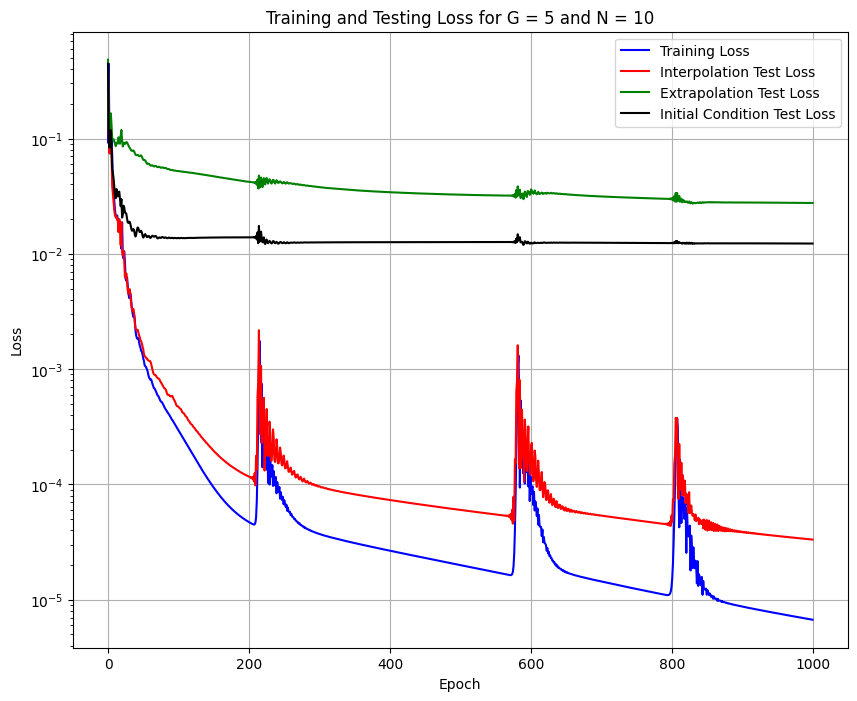

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_MWL_Testing.pdf


In [ ]:
# Plot training and testing loss for all configurations
plt.figure(figsize=(10, 8))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label="Training Loss",
        color = "blue"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyA"],
        label="Interpolation Test Loss",
        color = "red"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyB"],
        label="Extrapolation Test Loss",
        color = "green"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyD"],
        label="Initial Condition Test Loss",
        color="black"
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for G = 5 and N = 10")
plt.legend()
plt.grid(True)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/KANODE_MWL_Testing.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")

#Neural ODE


##Neural ODE Module

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Neural ODE Dynamics Function
class NeuralODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, y):
        return self.net(y)

# Training and Evaluation Data Preparation (Reuse from KANODE)
# Prepare Training Data
idx_ = [10, 30, 50, 70, 90, 110, 130, 150]
dt_train = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
Ey_train = np.array([Ey_sol[:, idx] for idx in idx_])
Hz_train = np.array([Hz_sol[:, idx] for idx in idx_])
time_steps = np.array(dt_train)

# Combine Ey and Hz into the initial conditions
xgrid_len = len(xgrid)
y0_train = torch.tensor(np.hstack([Ey_train[0], Hz_train[0]]), dtype=torch.float32)

# Prepare Ground Truth for Training
ground_truth_train = np.hstack([Ey_train, Hz_train])
ground_truth_tensor_train = torch.tensor(ground_truth_train, dtype=torch.float32)

# Prepare Testing Data
dt_test = np.arange(0, 1.6, 0.2)
Ey_test = np.array([Ey_sol[:, int(t / dt)] for t in dt_test])
Hz_test = np.array([Hz_sol[:, int(t / dt)] for t in dt_test])
ground_truth_test = np.hstack([Ey_test, Hz_test])
ground_truth_tensor_test = torch.tensor(ground_truth_test, dtype=torch.float32)

# Initial conditions for testing
y0_test = torch.tensor(np.hstack([Ey_test[0], Hz_test[0]]), dtype=torch.float32)  # Initial state for testing

# Time points for training evaluation
t_eval_train = torch.tensor(dt_train, dtype=torch.float32)  # Training time points

# Time points for testing evaluation
t_eval_test = torch.tensor(dt_test, dtype=torch.float32)  # Testing time points

##Training for different hyperparameters

Training model with Hidden Dim=225
Epoch 0, Training Loss: 0.028860684484243393, Testing Loss: 0.015673846006393433
Epoch 100, Training Loss: 1.0716355063777883e-05, Testing Loss: 4.0256498323287815e-05
Epoch 200, Training Loss: 8.771291390985425e-07, Testing Loss: 1.5253454876074102e-05
Epoch 300, Training Loss: 8.083961802185513e-07, Testing Loss: 1.1640026968962047e-05
Epoch 400, Training Loss: 1.2394773875712417e-05, Testing Loss: 5.199011866352521e-05
Epoch 500, Training Loss: 9.521570376591626e-08, Testing Loss: 1.0523091077629942e-05
Epoch 600, Training Loss: 8.619778668617073e-08, Testing Loss: 1.0819256203831173e-05
Epoch 700, Training Loss: 8.651023364336652e-08, Testing Loss: 9.274344847653992e-06
Epoch 800, Training Loss: 5.945703662746382e-08, Testing Loss: 9.60354464041302e-06
Epoch 900, Training Loss: 2.11825806673005e-07, Testing Loss: 8.010557394300122e-06
Metrics for Hidden Dim=225 saved.
Training model with Hidden Dim=250
Epoch 0, Training Loss: 0.02843654900789261, 

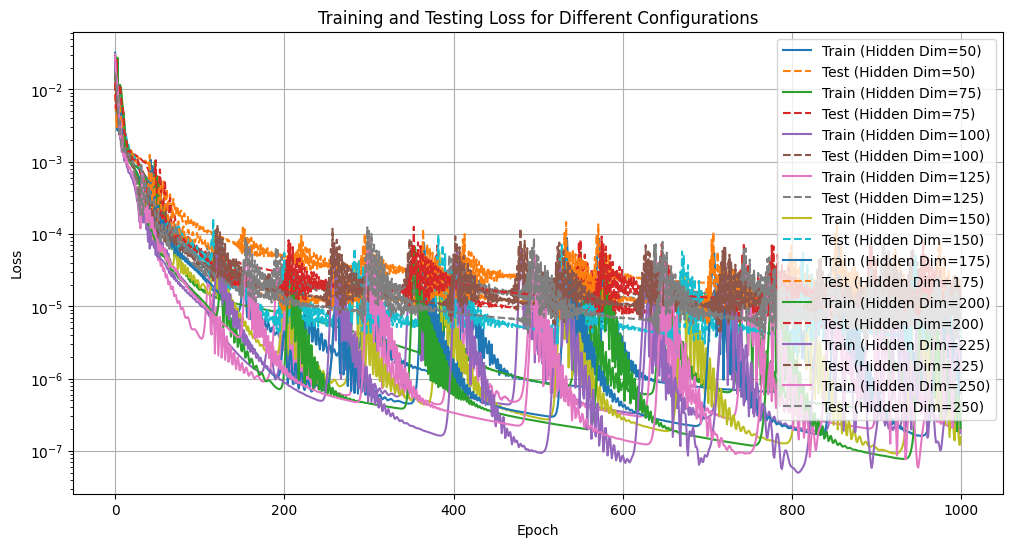

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Function to count the number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and benchmark the Neural ODE model
def train_and_benchmark_neural_ode_with_test(
    input_dim, hidden_dim, output_dim, lr, epochs, y0_train, ground_truth_tensor_train, y0_test, ground_truth_tensor_test, t_eval_train, t_eval_test, save_path="neural_ode_model.pth"
):
    # Instantiate the Neural ODE model
    neural_ode = NeuralODEFunc(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(neural_ode.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Count the number of model parameters
    num_parameters = count_parameters(neural_ode)

    # Initialize tracking variables
    start_time = time.time()
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        # Training step
        optimizer.zero_grad()
        pred_train = odeint(neural_ode, y0_train, t_eval_train)
        pred_train = pred_train.view(len(t_eval_train), -1)
        train_loss = loss_fn(pred_train, ground_truth_tensor_train)
        train_loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(train_loss.item())

        # Testing step
        with torch.no_grad():
            pred_test = odeint(neural_ode, y0_test, t_eval_test)
            pred_test = pred_test.view(len(t_eval_test), -1)
            test_loss = loss_fn(pred_test, ground_truth_tensor_test)
            test_loss_history.append(test_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Testing Loss: {test_loss.item()}")

    # Measure training time
    training_time = time.time() - start_time

    # Measure inference time
    neural_ode.eval()
    start_inference = time.time()
    with torch.no_grad():
        odeint(neural_ode, y0_test, t_eval_test)
    inference_time = time.time() - start_inference

    # Save the trained model
    torch.save(neural_ode.state_dict(), save_path)

    return {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "training_time": training_time,
        "inference_time": inference_time,
        "final_train_loss": train_loss_history[-1],
        "final_test_loss": test_loss_history[-1],
        "num_parameters": num_parameters,
        "train_loss_history": train_loss_history,
        "test_loss_history": test_loss_history,
        "model_path": save_path,
    }

# Load existing metrics
if os.path.exists("neural_ode_benchmark_metrics.json"):
    with open("neural_ode_benchmark_metrics.json", "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Training loop
lr = 1e-2
epochs = 1000

# Define range of hidden_dim
hidden_dim_range = [50, 75, 100, 125, 150, 175, 200, 225, 250]

for hidden_dim in hidden_dim_range:
    print(f"Training model with Hidden Dim={hidden_dim}")
    save_path = f"neural_ode_model_hidden_{hidden_dim}.pth"
    metrics = train_and_benchmark_neural_ode_with_test(
        input_dim=len(y0_train),
        hidden_dim=hidden_dim,
        output_dim=len(y0_train),
        lr=lr,
        epochs=epochs,
        y0_train=y0_train,
        ground_truth_tensor_train=ground_truth_tensor_train,
        y0_test=y0_test,
        ground_truth_tensor_test=ground_truth_tensor_test,
        t_eval_train=t_eval_train,
        t_eval_test=t_eval_test,
        save_path=save_path,
    )
    all_metrics.append(metrics)

    # Save metrics incrementally
    with open("neural_ode_benchmark_metrics.json", "w") as f:
        json.dump(all_metrics, f, indent=4)

    print(f"Metrics for Hidden Dim={hidden_dim} saved.")

# Plot training and testing loss for all configurations
plt.figure(figsize=(12, 6))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label=f"Train (Hidden Dim={metrics['hidden_dim']})",
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_history"],
        linestyle="--",
        label=f"Test (Hidden Dim={metrics['hidden_dim']})",
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for Different Configurations")
plt.legend()
plt.grid(True)
plt.show()


##Save all the trained models and metrics in Google Drive

In [ ]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the target directory in Google Drive
target_dir = '/content/drive/My Drive/PhD MIT/Deep Learning/Trained_Models_Maxwells/Neural_ODE/'

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Copy all saved models to the target directory
for metrics in all_metrics:
    model_path = metrics["model_path"]  # Get the saved model path from metrics
    if os.path.exists(model_path):  # Check if the model file exists
        shutil.copy(model_path, target_dir)
    else:
        print(f"Model file {model_path} not found!")

# Copy metrics file to the target directory
if os.path.exists("neural_ode_benchmark_metrics.json"):
    shutil.copy("neural_ode_benchmark_metrics.json", target_dir)
else:
    print("Metrics file not found!")

print(f"All Neural ODE models and metrics have been saved to: {target_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All Neural ODE models and metrics have been saved to: /content/drive/My Drive/PhD MIT/Deep Learning/Trained_Models_Maxwells/Neural_ODE/


##Loading the saved models from Google Drive and plotting metrics

In [ ]:
from google.colab import drive
import os
import torch
import json

# Mount Google Drive
drive.mount('/content/drive')

# Define the target directory in Google Drive
source_dir = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/Neural_ODE/'

# Load metrics from the JSON file
metrics_file = os.path.join(source_dir, "neural_ode_benchmark_metrics.json")
if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        all_metrics = json.load(f)
    print("Metrics loaded successfully!")
else:
    print(f"Metrics file not found in {source_dir}!")

# Load models from the saved paths
loaded_models = {}
for metrics in all_metrics:
    model_path = os.path.join(source_dir, os.path.basename(metrics["model_path"]))
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")
        # Recreate the Neural ODE model architecture
        input_dim = metrics["input_dim"]
        hidden_dim = metrics["hidden_dim"]
        output_dim = metrics["output_dim"]
        neural_ode_model = NeuralODEFunc(input_dim, hidden_dim, output_dim)  # Replace with your Neural ODE model class
        neural_ode_model.load_state_dict(torch.load(model_path))
        neural_ode_model.eval()
        loaded_models[f'H={hidden_dim}'] = neural_ode_model
    else:
        print(f"Model file {model_path} not found!")

# Print loaded models
print(f"Loaded Neural ODE models: {list(loaded_models.keys())}")


<ipython-input-17-bfb97c2d5987>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('neural_ode_func.pth')


NeuralODEFunc(
  (net): Sequential(
    (0): Linear(in_features=202, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=202, bias=True)
  )
)

##Neural ODE Results

###Scaling Plot

Mounted at /content/drive


<ipython-input-1-7403eb19b77d>:26: RuntimeWarning: overflow encountered in power
  return C * (x ** alpha)


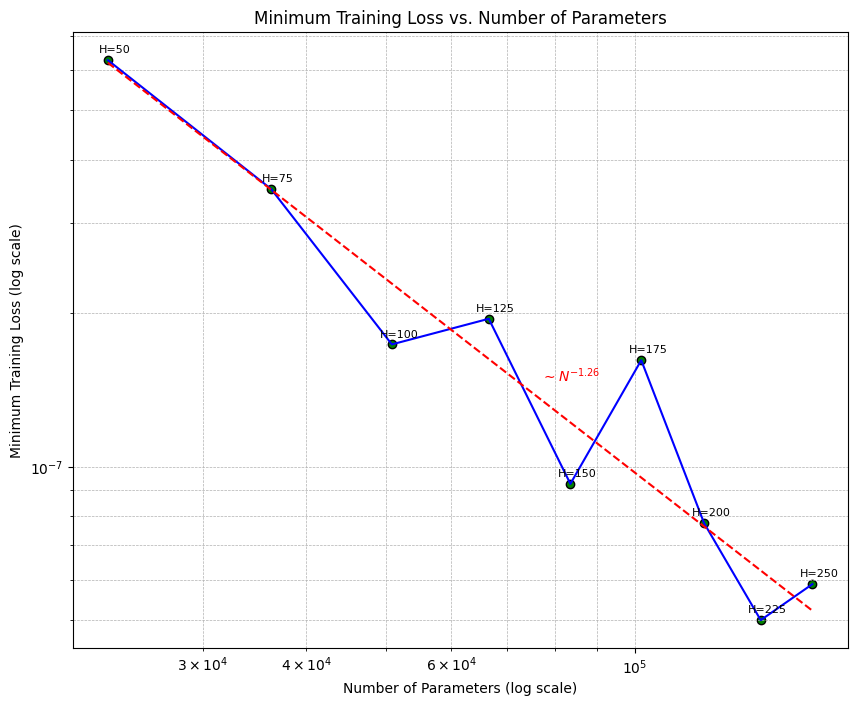

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_MWL_Scaling.pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.optimize import curve_fit
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your JSON file in Google Drive
file_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/Neural_ODE_Final/neural_ode_benchmark_metrics.json"

# Load metrics from the JSON file
with open(file_path, "r") as f:
    filtered_metrics = json.load(f)

# Extract data from metrics
training_times = [metrics["training_time"] for metrics in filtered_metrics]
inference_times = [metrics["inference_time"] for metrics in filtered_metrics]
min_train_losses = [min(metrics["train_loss_history"]) for metrics in filtered_metrics]  # Minimum training loss
num_parameters = [metrics["num_parameters"] for metrics in filtered_metrics]
hidden_dims = [metrics["hidden_dim"] for metrics in filtered_metrics]  # Hidden dimensions

# Define the scaling function
def scaling_law(x, C, alpha):
    return C * (x ** alpha)

plt.figure(figsize=(10, 8))

# Loss vs. Number of Parameters
plt.scatter(num_parameters, min_train_losses, color="green", edgecolor="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Parameters (log scale)")
plt.ylabel("Minimum Training Loss (log scale)")
plt.title("Minimum Training Loss vs. Number of Parameters")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Join points with a piecewise blue line
sorted_indices = np.argsort(hidden_dims)
sorted_num_parameters = np.array(num_parameters)[sorted_indices]
sorted_min_train_losses = np.array(min_train_losses)[sorted_indices]
sorted_hidden_dims = np.array(hidden_dims)[sorted_indices]

plt.plot(sorted_num_parameters, sorted_min_train_losses, linestyle="-", color="blue", linewidth=1.5)

# Fit scaling law
params, _ = curve_fit(scaling_law, sorted_num_parameters, sorted_min_train_losses, p0=[1e-8, -1], maxfev=10000)
C, alpha = params

# Plot fitted scaling law
plt.plot(sorted_num_parameters, scaling_law(sorted_num_parameters, C, alpha), linestyle="--", color="red", linewidth=1.5)

# Annotate the scaling law
mid_x = np.median(sorted_num_parameters)
mid_y = scaling_law(mid_x, C, alpha)
plt.text(mid_x, 1.2*mid_y, f"$\\sim N^{{{alpha:.2f}}}$", fontsize=10, ha="center", color="red")

# Annotate points with "H="
for i in range(len(sorted_num_parameters)):
    plt.annotate(f"H={sorted_hidden_dims[i]}",
                 (sorted_num_parameters[i], sorted_min_train_losses[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center", fontsize=8)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_MWL_Scaling.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")


###Times Plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


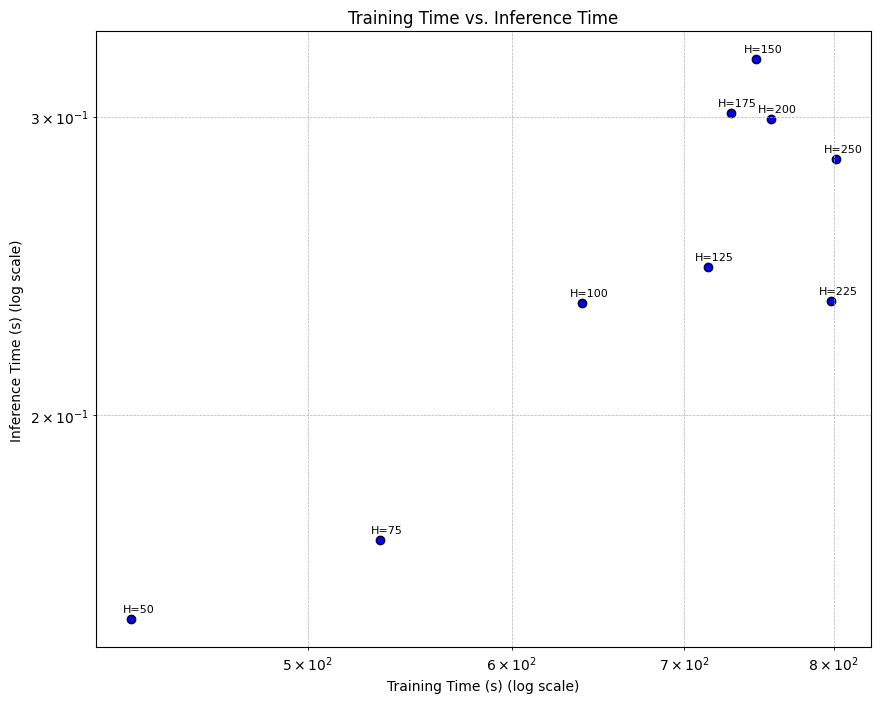

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_MWL_Times.pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your JSON file in Google Drive
file_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/Neural_ODE_Final/neural_ode_benchmark_metrics.json"

# Load metrics from the JSON file
with open(file_path, "r") as f:
    filtered_metrics = json.load(f)

# Extract data from metrics
training_times = [metrics["training_time"] for metrics in filtered_metrics]
inference_times = [metrics["inference_time"] for metrics in filtered_metrics]
min_train_losses = [min(metrics["train_loss_history"]) for metrics in filtered_metrics]  # Minimum training loss
num_parameters = [metrics["num_parameters"] for metrics in filtered_metrics]
hidden_dims = [metrics["hidden_dim"] for metrics in filtered_metrics]  # Hidden dimensions


plt.figure(figsize=(10, 8))

# Training Time vs. Inference Time
plt.scatter(training_times, inference_times, color="blue", edgecolor="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training Time (s) (log scale)")
plt.ylabel("Inference Time (s) (log scale)")
plt.title("Training Time vs. Inference Time")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Add annotations for hidden dimensions
for i in range(len(training_times)):
    plt.annotate(f"H={hidden_dims[i]}",
                 (training_times[i], inference_times[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center", fontsize=8)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_MWL_Times.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")

###Loss Curve

Mounted at /content/drive


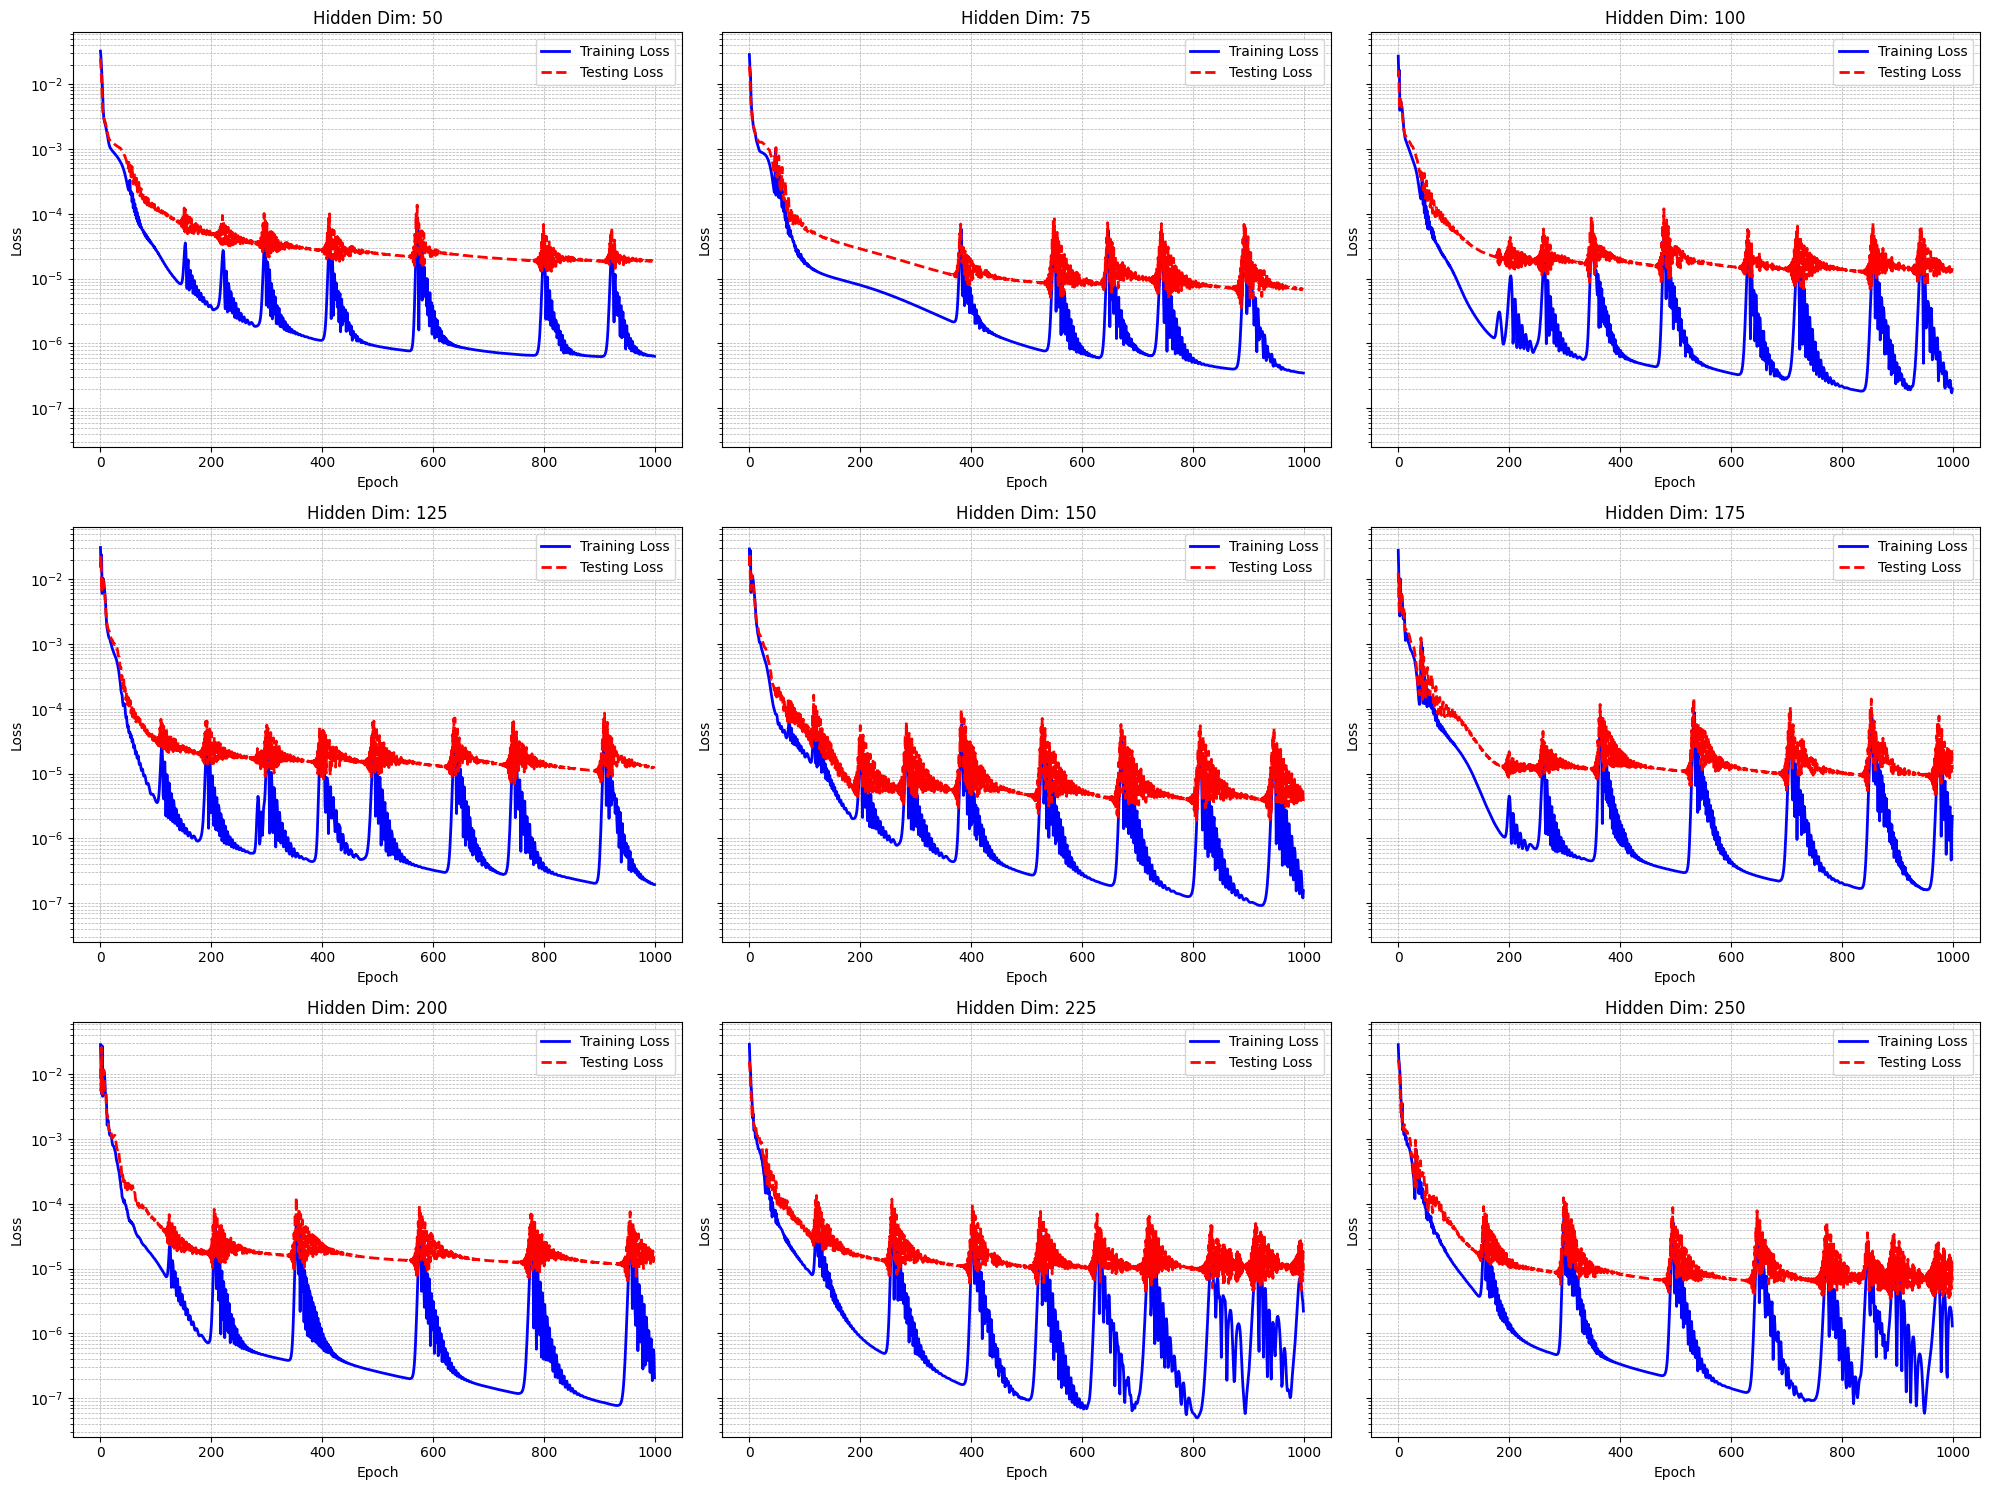

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_MWL_Loss.pdf


In [ ]:
import matplotlib.pyplot as plt
import json
import math
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your JSON file in Google Drive
file_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/Neural_ODE_Final/neural_ode_benchmark_metrics.json"

# Load metrics from the JSON file
with open(file_path, "r") as f:
    filtered_metrics = json.load(f)

# Determine the number of configurations
num_configs = len(filtered_metrics)

# Calculate rows and columns for subplots
cols = 3  # Set the number of columns
rows = math.ceil(num_configs / cols)  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharey=True)
axes = axes.flatten()  # Flatten for easy indexing

# Plot each configuration
for i, metrics in enumerate(filtered_metrics):
    hidden_dim = metrics["hidden_dim"]
    train_loss_history = metrics["train_loss_history"]
    test_loss_history = metrics["test_loss_history"]

    # Plot training and testing loss in the respective subplot
    axes[i].plot(train_loss_history, label="Training Loss", color="blue", linewidth=2)
    axes[i].plot(test_loss_history, label="Testing Loss", color="red", linestyle="--", linewidth=2)

    # Configure subplot
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
    axes[i].set_title(f"Hidden Dim: {hidden_dim}")
    axes[i].legend()
    axes[i].grid(True, which="both", linestyle="--", linewidth=0.5)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_MWL_Loss.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")

##Neural ODE Field Visualization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


<ipython-input-92-041a8405cdb6>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  neural_ode.load_state_dict(torch.load(trained_model_path, map_location=torch.device('cpu'))

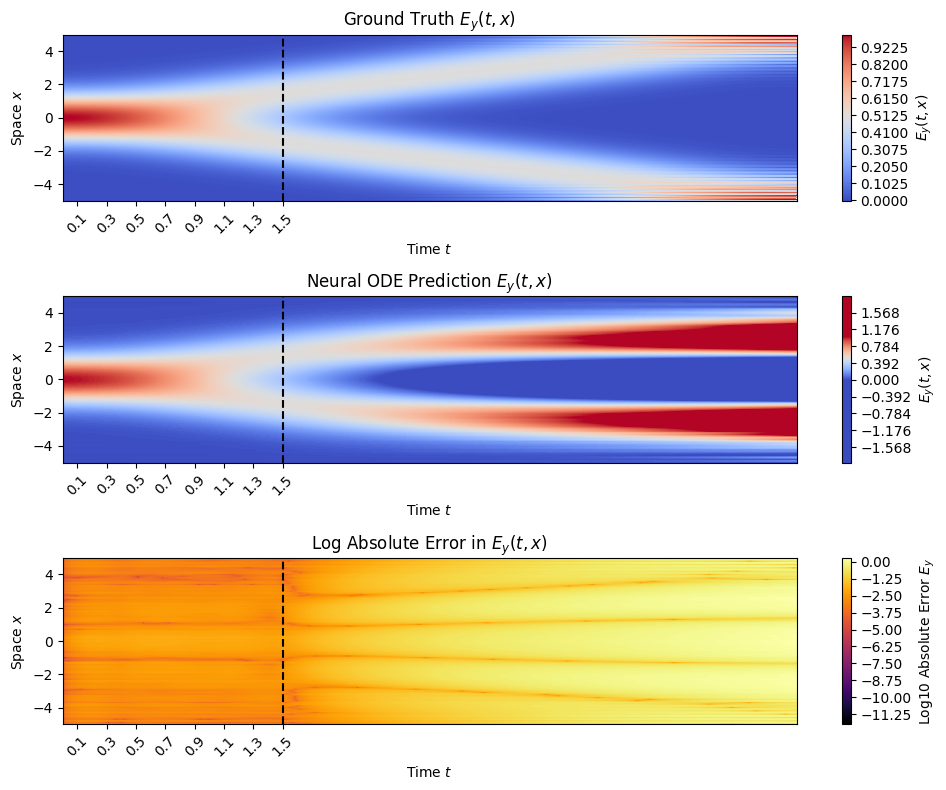

Plot saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_field_visual.pdf


In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

drive.mount('/content/drive')

# Define the path to your trained model in Drive
trained_model_path = '/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Trained_Models_Maxwells/Neural_ODE_Final/neural_ode_model_hidden_250.pth'

# Define the model parameters
hidden_dim = 250  # Replace with the hidden dimension of your Neural ODE
xgrid_len = 101  # Example value; replace with the actual spatial grid length

# Prepare initial conditions and time grid
y0_test = torch.tensor(np.hstack([Ey_sol.T[0], Hz_sol.T[0]]), dtype=torch.float32)
t_eval_test = torch.tensor(tgrid, dtype=torch.float32)

# Load the trained model
neural_ode = NeuralODEFunc(input_dim=2 * xgrid_len, hidden_dim=hidden_dim, output_dim = len(y0_train))
neural_ode.load_state_dict(torch.load(trained_model_path, map_location=torch.device('cpu')))
neural_ode.eval()  # Set the model to evaluation mode

print("Model loaded successfully!")

# Evaluate the model
with torch.no_grad():
    pred_output = odeint(neural_ode, y0_test, t_eval_test)
    pred_output = pred_output.numpy()

pred_Ey = pred_output[:, :xgrid_len]  # Predicted E_y
pred_Hz = pred_output[:, xgrid_len:]

Ey_abs_error = np.abs(Ey_sol.T - pred_Ey)
log_Ey_abs_error = np.log10(np.clip(Ey_abs_error, a_min=1e-12, a_max=None))  # Avoid log(0) by clipping

# File path for saving the PDF
output_pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/Neural_ODE_field_visual.pdf"

# Plotting results in a single column
plt.figure(figsize=(10, 8))

# Define vmin and vmax based on the ground truth
vmin = Ey_sol.min()
vmax = Ey_sol.max()

# Ground Truth E_y (Contour Plot)
plt.subplot(3, 1, 1)
contour_Ey_truth = plt.contourf(tgrid, xgrid, Ey_sol, levels=500, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(contour_Ey_truth, label='$E_y(t,x)$')
plt.title('Ground Truth $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

# Predicted E_y (Contour Plot)
plt.subplot(3, 1, 2)
contour_pred_Ey = plt.contourf(tgrid, xgrid, pred_Ey.T, levels=500, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(contour_pred_Ey, label='$E_y(t,x)$')
plt.title('Neural ODE Prediction $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

# Log Absolute Error E_y (Contour Plot)
plt.subplot(3, 1, 3)
contour_log_error = plt.contourf(tgrid, xgrid, log_Ey_abs_error.T, levels=500, cmap='inferno')
plt.colorbar(contour_log_error, label='Log10 Absolute Error $E_y$')
plt.title('Log Absolute Error in $E_y(t,x)$')
plt.xlabel('Time $t$')
plt.ylabel('Space $x$')
plt.xticks(dt_train, labels=[f"{t:.1f}" for t in dt_train], rotation=45)  # Tick marks at training steps
plt.axvline(x=last_training_time, color="black", linestyle="--", label="Last Training Time")  # Vertical line

plt.tight_layout()

# Save the figure as a PDF
plt.savefig(output_pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Plot saved as PDF at: {output_pdf_path}")


##Testing

Here we select a particular KAN-ODE hyperparameter, H = 250. We use this model, and test it for the following three different testing dataset.

1. Test set A: Interpolated time
2. Test set B: Extrapolated time
3. Test set C, D: Change the initial condition

###Creating Testing Dataset

In [ ]:
# Parameters
xspan = (-5.0, 5.0)
tspan = (0.0, 5.0)
dx = 0.1
dt = 0.01
xgrid = np.arange(xspan[0], xspan[1] + dx, dx)
tgrid = np.arange(tspan[0], tspan[1] + dt, dt)
mu = 1.0  # Permeability
epsilon = 1.0  # Permittivity

# Initial conditions (Gaussian pulse for E_y, H_z initially zero)
def gaussian(x, x0=0.0, sigma=1.0):
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

Ey_init = gaussian(xgrid, x0=0.0, sigma=1.0)
Hz_init = np.zeros_like(xgrid)

Ey_init2 = gaussian(xgrid, x0=2.0, sigma=1.0)
Hz_init2 = np.zeros_like(xgrid)

Ey_init3 = gaussian(xgrid, x0=0.0, sigma=2.0)
Hz_init3 = np.zeros_like(xgrid)

# Discretization
def maxwell_rhs(t, y, dx, N, mu, epsilon):
    Ey = y[:N]
    Hz = y[N:]
    dEy_dx = np.zeros_like(Ey)
    dHz_dx = np.zeros_like(Hz)

    # Finite difference (PEC boundary conditions)
    for i in range(1, N-1):
        dEy_dx[i] = (Ey[i+1] - Ey[i-1]) / (2 * dx)
        dHz_dx[i] = (Hz[i+1] - Hz[i-1]) / (2 * dx)

    # PEC boundary conditions (Ey=0 at boundaries)
    dEy_dx[0] = dEy_dx[-1] = 0
    dHz_dx[0] = dHz_dx[-1] = 0

    # RHS of Maxwell's equations
    dEy_dt = -(1 / epsilon) * dHz_dx
    dHz_dt = -(1 / mu) * dEy_dx

    return np.concatenate([dEy_dt, dHz_dt])

# Solve the system
N = len(xgrid)
y0 = np.concatenate([Ey_init, Hz_init])
sol = solve_ivp(maxwell_rhs, tspan, y0, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

y2 = np.concatenate([Ey_init2, Hz_init2])
sol2 = solve_ivp(maxwell_rhs, tspan, y2, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

y3 = np.concatenate([Ey_init3, Hz_init3])
sol3 = solve_ivp(maxwell_rhs, tspan, y3, method='RK45', t_eval=tgrid, args=(dx, N, mu, epsilon))

# Extract solutions
Ey_sol = sol.y[:N, :]
Hz_sol = sol.y[N:, :]

Ey_sol2 = sol2.y[:N, :]
Hz_sol2 = sol2.y[N:, :]

Ey_sol3 = sol3.y[:N, :]
Hz_sol3 = sol3.y[N:, :]

# Extract training data from the Maxwell solution
idx_ = [10, 30, 50, 70, 90, 110, 130, 150]
dt_train = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
Ey_train = np.array([Ey_sol[:, idx] for idx in idx_])
Hz_train = np.array([Hz_sol[:, idx] for idx in idx_])
time_steps = np.array(dt_train)

# Prepare data
spatial_grid = np.repeat(xgrid.reshape(1, -1), len(time_steps), axis=0)
temporal_grid = np.repeat(time_steps.reshape(-1, 1), len(xgrid), axis=1)

# Combine spatial, temporal, and fields (Ey, Hz) as input
input_data = np.stack([spatial_grid, temporal_grid, Ey_train], axis=-1)
output_data = np.stack([Ey_train, Hz_train], axis=-1)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Define the 2 test time grids
dt_testA = np.arange(0, 1.6, 0.2)  # Test times from 1.5 to 5.0 with spacing of 0.1
dt_testB = np.arange(1.6, 3.2, 0.2)

# Extract test data for Ey and Hz
Ey_testA = np.array([Ey_sol[:, int(t / dt)] for t in dt_testA])
Hz_testA = np.array([Hz_sol[:, int(t / dt)] for t in dt_testA])

Ey_testB = np.array([Ey_sol[:, int(t / dt)] for t in dt_testB])
Hz_testB = np.array([Hz_sol[:, int(t / dt)] for t in dt_testB])

Ey_testC = np.array([Ey_sol2[:, int(t / dt)] for t in dt_train])
Hz_testC = np.array([Hz_sol2[:, int(t / dt)] for t in dt_train])

Ey_testD = np.array([Ey_sol3[:, int(t / dt)] for t in dt_train])
Hz_testD = np.array([Hz_sol3[:, int(t / dt)] for t in dt_train])


# Combine Ey and Hz into the initial conditions
xgrid_len = len(xgrid)
y0_train = torch.tensor(np.hstack([Ey_train[0], Hz_train[0]]), dtype=torch.float32)

# Prepare Ground Truth for Training
ground_truth_train = np.hstack([Ey_train, Hz_train])
ground_truth_tensor_train = torch.tensor(ground_truth_train, dtype=torch.float32)

# Prepare Testing Data
ground_truth_testA = np.hstack([Ey_testA, Hz_testA])
ground_truth_tensor_testA = torch.tensor(ground_truth_testA, dtype=torch.float32)

ground_truth_testB = np.hstack([Ey_testB, Hz_testB])
ground_truth_tensor_testB = torch.tensor(ground_truth_testB, dtype=torch.float32)

ground_truth_testC = np.hstack([Ey_testC, Hz_testC])
ground_truth_tensor_testC = torch.tensor(ground_truth_testC, dtype=torch.float32)

ground_truth_testD = np.hstack([Ey_testD, Hz_testD])
ground_truth_tensor_testD = torch.tensor(ground_truth_testD, dtype=torch.float32)

# Initial conditions for testing
y0_testA = torch.tensor(np.hstack([Ey_testA[0], Hz_testA[0]]), dtype=torch.float32)  # Initial state for testing
y0_testB = torch.tensor(np.hstack([Ey_testB[0], Hz_testB[0]]), dtype=torch.float32)
y0_testC = torch.tensor(np.hstack([Ey_testC[0], Hz_testC[0]]), dtype=torch.float32)
y0_testD = torch.tensor(np.hstack([Ey_testD[0], Hz_testD[0]]), dtype=torch.float32)

# Time points for training evaluation
t_eval_train = torch.tensor(dt_train, dtype=torch.float32)  # Training time points

# Time points for testing evaluation
t_eval_testA = torch.tensor(dt_testA, dtype=torch.float32)  # Testing time points
t_eval_testB = torch.tensor(dt_testB, dtype=torch.float32)  # Testing time points
t_eval_testC = torch.tensor(dt_train, dtype=torch.float32)  # Testing time points
t_eval_testD = torch.tensor(dt_train, dtype=torch.float32)  # Testing time points

###Training

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from torchdiffeq import odeint  # For Neural ODE

# Function to count the number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and benchmark the Neural ODE model
def neural_ode_testing(input_dim,
    hidden_dim, output_dim, lr, epochs, y0_train, ground_truth_tensor_train, y0_test, ground_truth_tensor_test, t_eval_train, t_eval_test, save_path="neural_ode_model.pth"
):
    # Instantiate the Neural ODE model
    neural_ode = NeuralODEFunc(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(neural_ode.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    # Count the number of model parameters
    num_parameters = count_parameters(neural_ode)

    # Initialize tracking variables
    start_time = time.time()
    train_loss_history = []
    test_loss_historyA = []
    test_loss_historyB = []
    test_loss_historyC = []
    test_loss_historyD = []

    for epoch in range(epochs):
        # Training step
        optimizer.zero_grad()
        pred_train = odeint(neural_ode, y0_train, t_eval_train)
        pred_train = pred_train.view(len(t_eval_train), -1)
        train_loss = loss_fn(pred_train, ground_truth_tensor_train)
        train_loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(train_loss.item())

        # Testing step
        with torch.no_grad():
            pred_testA = odeint(neural_ode, y0_test[0], t_eval_test[0])
            pred_testA = pred_testA.view(len(t_eval_test[0]), -1)
            test_lossA = loss_fn(pred_testA, ground_truth_tensor_test[0])
            test_loss_historyA.append(test_lossA.item())

            pred_testB = odeint(neural_ode, y0_test[1], t_eval_test[1])
            pred_testB = pred_testB.view(len(t_eval_test[1]), -1)
            test_lossB = loss_fn(pred_testB, ground_truth_tensor_test[1])
            test_loss_historyB.append(test_lossB.item())

            pred_testC = odeint(neural_ode, y0_test[2], t_eval_test[2])
            pred_testC = pred_testC.view(len(t_eval_test[2]), -1)
            test_lossC = loss_fn(pred_testC, ground_truth_tensor_test[2])
            test_loss_historyC.append(test_lossC.item())

            pred_testD = odeint(neural_ode, y0_test[3], t_eval_test[3])
            pred_testD = pred_testD.view(len(t_eval_test[3]), -1)
            test_lossD = loss_fn(pred_testD, ground_truth_tensor_test[3])
            test_loss_historyD.append(test_lossD.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Testing Loss A: {test_lossA.item()}, Testing Loss B: {test_lossB.item()}, Testing Loss C: {test_lossC.item()}, Testing Loss D: {test_lossD.item()}")

    # Measure training time
    training_time = time.time() - start_time

    # Measure inference time
    neural_ode.eval()
    start_inference = time.time()
    with torch.no_grad():
        odeint(neural_ode, y0_test[0], t_eval_test[0])
    inference_time = time.time() - start_inference

    # Save the trained model
    torch.save(neural_ode.state_dict(), save_path)

    return {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "training_time": training_time,
        "inference_time": inference_time,
        "final_train_loss": train_loss_history[-1],
        "final_test_lossA": test_loss_historyA[-1],
        "final_test_lossB": test_loss_historyB[-1],
        "final_test_lossC": test_loss_historyC[-1],
        "final_test_lossD": test_loss_historyD[-1],
        "num_parameters": num_parameters,
        "train_loss_history": train_loss_history,
        "test_loss_historyA": test_loss_historyA,
        "test_loss_historyB": test_loss_historyB,
        "test_loss_historyC": test_loss_historyC,
        "test_loss_historyD": test_loss_historyD,
        "model_path": save_path,
    }


In [ ]:
import os
import matplotlib.pyplot as plt
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load existing metrics
if os.path.exists("neural_ode_testing_metrics.json"):
    with open("neural_ode_testing_metrics.json", "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Training loop parameters
lr = 1e-2
epochs = 1000

# Define range of hidden dimensions for Neural ODE
hidden_dim_range = [250]

for hidden_dim in hidden_dim_range:
    print(f"Training model with hidden_dim={hidden_dim}")
    save_path = f"neural_ode_model_hidden_{hidden_dim}.pth"

    # Call the testing function for Neural ODE
    metrics = neural_ode_testing(
        input_dim = len(y0_train),
        hidden_dim=hidden_dim,
        output_dim = len(y0_train),
        lr=lr,
        epochs=epochs,
        y0_train=y0_train,
        ground_truth_tensor_train=ground_truth_tensor_train,
        y0_test=[y0_testA, y0_testB, y0_testC, y0_testD],
        ground_truth_tensor_test=[ground_truth_tensor_testA, ground_truth_tensor_testB, ground_truth_tensor_testC, ground_truth_tensor_testD],
        t_eval_train=t_eval_train,
        t_eval_test=[t_eval_testA, t_eval_testB, t_eval_testC, t_eval_testD],
        save_path=save_path,
    )

    # Append metrics for the current configuration
    all_metrics.append(metrics)

    # Save metrics incrementally
    with open("neural_ode_testing_metrics.json", "w") as f:
        json.dump(all_metrics, f, indent=4)

    print(f"Metrics for hidden_dim={hidden_dim} saved.")



Mounted at /content/drive
Training model with hidden_dim=250
Epoch 0, Training Loss: 0.02805420011281967, Testing Loss A: 0.018564987927675247, Testing Loss B: 0.06741301715373993, Testing Loss C: 0.06064707785844803, Testing Loss D: 0.06436486542224884
Epoch 100, Training Loss: 1.4214419934432954e-05, Testing Loss A: 5.924878132645972e-05, Testing Loss B: 0.03147941455245018, Testing Loss C: 0.06343673914670944, Testing Loss D: 0.010271009057760239
Epoch 200, Training Loss: 1.478941385357757e-06, Testing Loss A: 1.4270352949097287e-05, Testing Loss B: 0.019006503745913506, Testing Loss C: 0.055391523987054825, Testing Loss D: 0.009944726713001728
Epoch 300, Training Loss: 8.133722985803615e-06, Testing Loss A: 0.00011765467206714675, Testing Loss B: 0.018158167600631714, Testing Loss C: 0.05547444149851799, Testing Loss D: 0.009804177097976208
Epoch 400, Training Loss: 3.0394397754207603e-07, Testing Loss A: 1.2328265256655868e-05, Testing Loss B: 0.016257526353001595, Testing Loss C:

###Plotting

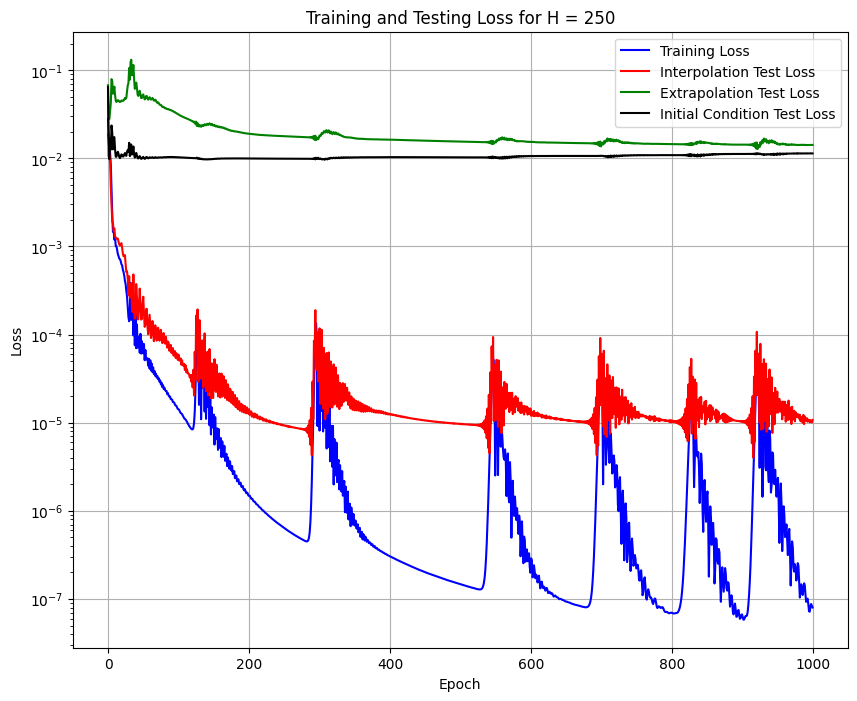

Figure saved as PDF at: /content/drive/My Drive/PhD MIT/Deep Learning/Final Project/NeuralODE_MWL_Testing.pdf


In [ ]:
# Plot training and testing loss for all configurations
plt.figure(figsize=(10, 8))
for metrics in all_metrics:
    epochs_range = range(metrics["epochs"])
    plt.plot(
        epochs_range,
        metrics["train_loss_history"],
        label="Training Loss",
        color = "blue"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyA"],
        label="Interpolation Test Loss",
        color = "red"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyB"],
        label="Extrapolation Test Loss",
        color = "green"
    )
    plt.plot(
        epochs_range,
        metrics["test_loss_historyD"],
        label="Initial Condition Test Loss",
        color="black"
    )
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss for H = 250")
plt.legend()
plt.grid(True)

# Save the figure as a PDF
pdf_path = "/content/drive/My Drive/PhD MIT/Deep Learning/Final Project/NeuralODE_MWL_Testing.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

# Display the figure
plt.show()

print(f"Figure saved as PDF at: {pdf_path}")

#Benchmarking Framework

##Evaluating Metrics

Evaluating Neural ODE...
Evaluating KANODE...
Evaluating FNO...
        Model  Inference Time (s)       MSE      nMSE
0  Neural ODE            0.095858  0.144725  2.000355
1      KANODE            0.466928  0.145166  2.006455
2         FNO            0.019933  0.145296  2.008248


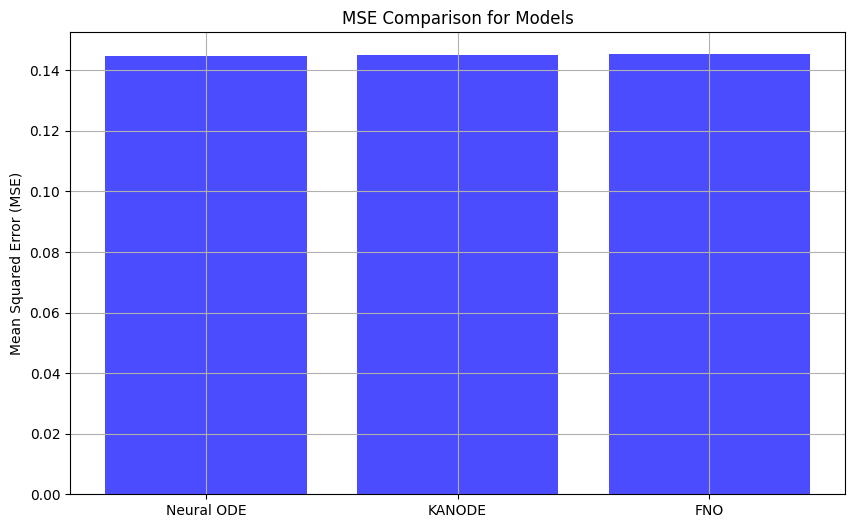

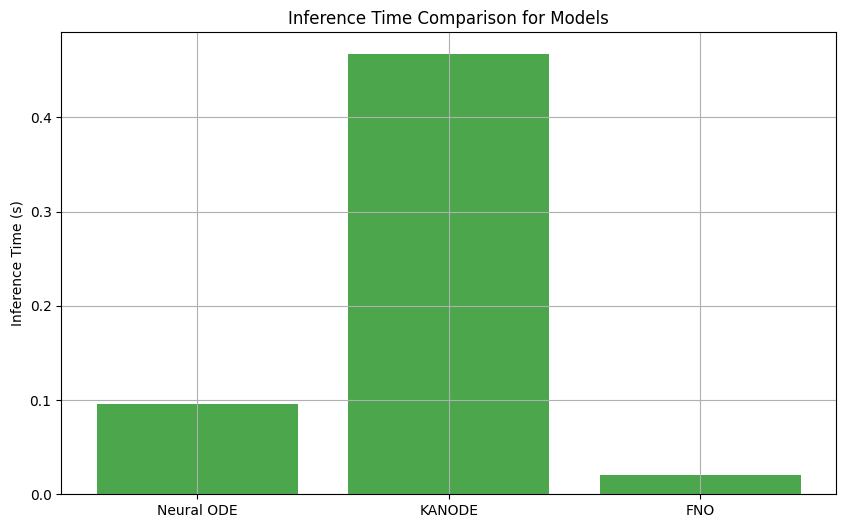

In [ ]:
import time
from sklearn.metrics import mean_squared_error


def benchmark_model(model, model_name, y0, t_eval, ground_truth, is_fno=False):
    """
    Benchmark a single model for inference time and normalized MSE.

    Args:
    - model (torch.nn.Module): The trained model to evaluate.
    - model_name (str): Name of the model (for logging).
    - y0 (torch.Tensor): Initial condition for the ODE solver (None for FNO).
    - t_eval (torch.Tensor): Time points for evaluation.
    - ground_truth (numpy.ndarray): Ground truth data for comparison.
    - is_fno (bool): Whether the model is an FNO.

    Returns:
    - dict: Metrics including inference time and normalized MSE.
    """
    print(f"Evaluating {model_name}...")

    # Measure inference time
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        if is_fno:
            # FNO predictions (no y0 or odeint needed)
            pred_output = model(input_tensor).numpy()  # Assuming input_tensor is predefined
        else:
            # Neural ODE or KANODE predictions
            pred_output = odeint(model, y0, t_eval).numpy()
    inference_time = time.time() - start_time

    # Compute MSE and normalized MSE
    mse = mean_squared_error(ground_truth.flatten(), pred_output.flatten())
    variance = np.var(ground_truth.flatten())  # Variance of the ground truth
    nmse = mse / variance  # Normalized MSE

    return {"Model": model_name, "Inference Time (s)": inference_time, "MSE": mse, "nMSE": nmse}



# Initialize benchmark results
benchmark_results = []

# Benchmark Neural ODE model
benchmark_results.append(benchmark_model(neural_ode_func, "Neural ODE", y0, t_eval, ground_truth))

# Benchmark KANODE model
benchmark_results.append(benchmark_model(kanode, "KANODE", y0, t_eval, ground_truth))

# Benchmark FNO model (Assuming predictions only at training times)
benchmark_results.append(benchmark_model(fno_model, "FNO", None, t_eval, ground_truth, is_fno = True))

# Display Benchmark Results
import pandas as pd
results_df = pd.DataFrame(benchmark_results)
print(results_df)

# Plot Benchmarking Results
import matplotlib.pyplot as plt

# Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["MSE"], color='blue', alpha=0.7)
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE Comparison for Models")
plt.grid(True)

# Plot Inference Time
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Inference Time (s)"], color='green', alpha=0.7)
plt.ylabel("Inference Time (s)")
plt.title("Inference Time Comparison for Models")
plt.grid(True)

plt.show()


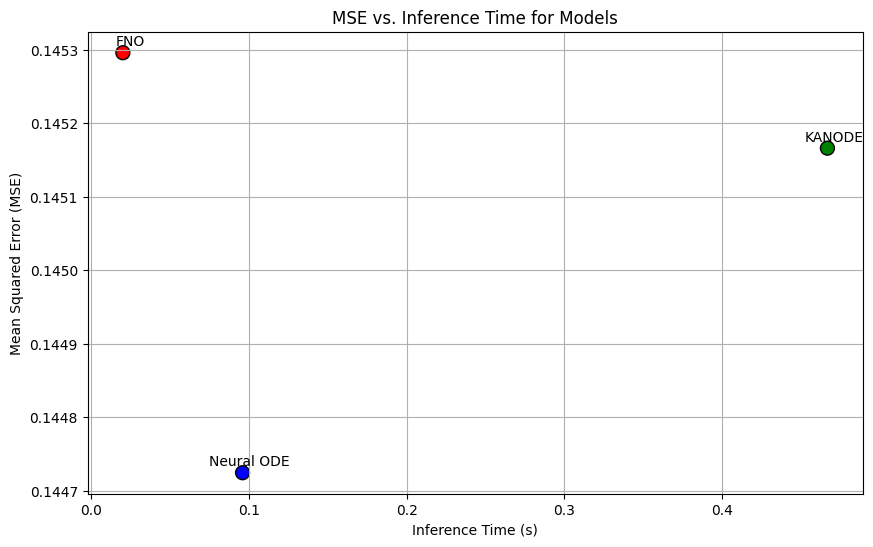

In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
models = results_df["Model"]
mse = results_df["MSE"]
inference_time = results_df["Inference Time (s)"]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(inference_time, mse, color=['blue', 'green', 'red'], s=100, edgecolor='black', label=models)

# Annotate model names
for i, model in enumerate(models):
    plt.annotate(model, (inference_time[i], mse[i]), textcoords="offset points", xytext=(5, 5), ha="center")

# Add labels, title, and grid
plt.xlabel("Inference Time (s)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Inference Time for Models")
plt.grid(True)
plt.show()
